In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binomtest
import os
import re
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

In [2]:
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D

In [3]:
PATH=os.getcwd()+'/data/out'

### read original data

In [4]:
df_wilson = pd.read_csv('data/in/allHorizonData_cut.csv')

In [5]:
df_wilson.columns

Index(['expt_name', 'subjectID', 'subjectNumber', 'block', 'game',
       'gameLength', 'uc', 'm1', 'm2', 'gID', 'repeatNumber', 'r1', 'r2', 'r3',
       'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'c1', 'c2', 'c3', 'c4', 'c5',
       'c6', 'c7', 'c8', 'c9', 'c10', 'rt1', 'rt2', 'rt3', 'rt4', 'rt5', 'rt6',
       'rt7', 'rt8', 'rt9', 'rt10'],
      dtype='object')

In [6]:
df_wilson_reaction_times=df_wilson[[f'rt{i}' for i in range(1,11)]].to_numpy()

In [7]:
df_pilot=df_wilson[df_wilson['expt_name']=='pilot-v1']

In [8]:
def process_subjects(df):
    subjects = []
    subject_ids = df['subjectNumber'].unique()

    for sn in subject_ids:
        sub_df = df[df['subjectNumber'] == sn].reset_index(drop=True)
        sub = {}

        # Basic info
        sub['expt_name'] = sub_df.loc[0, 'expt_name']
        sub['subjectID'] = sub_df.loc[0, 'subjectID']
        sub['subjectNumber'] = sn

        # Columns
        sub['block'] = sub_df['block'].values
        sub['game'] = sub_df['game'].values
        sub['gameLength'] = sub_df['gameLength'].values
        sub['uc'] = sub_df['uc'].values
        sub['m1'] = sub_df['m1'].values
        sub['m2'] = sub_df['m2'].values
        sub['gID'] = sub_df['gID'].values
        sub['repeatNumber'] = sub_df['repeatNumber'].values

        r = sub_df[[f'r{i}' for i in range(1, 11)]].to_numpy()
        a = sub_df[[f'c{i}' for i in range(1, 11)]].to_numpy()
        RT = sub_df[[f'rt{i}' for i in range(1, 11)]].to_numpy()

        sub['r'] = r
        sub['a'] = a
        sub['RT'] = RT

        # z-scored RT
        sub['RTz'] = (RT - np.nanmean(RT)) / np.nanstd(RT)

        # Cumulative choices
        sub['n1'] = np.cumsum(a == 1, axis=1)
        sub['n2'] = np.cumsum(a == 2, axis=1)

        # Cumulative rewards
        sub['R1'] = np.cumsum(r * (a == 1), axis=1)
        sub['R2'] = np.cumsum(r * (a == 2), axis=1)

        # Observed mean
        sub['o1'] = sub['R1'] / sub['n1']
        sub['o2'] = sub['R2'] / sub['n2']

        # Correct choice
        m1 = sub['m1'][:, np.newaxis]
        m2 = sub['m2'][:, np.newaxis]
        co = ((m1 > m2) * (a == 1)) + ((m1 < m2) * (a == 2))
        co[np.isnan(a)] = np.nan
        sub['co'] = co

        # Low observed mean (random exploration)
        o1 = sub['o1']
        o2 = sub['o2']
        lm = ((o1[:, :-1] < o2[:, :-1]) * (a[:, 1:] == 1)) + \
             ((o1[:, :-1] > o2[:, :-1]) * (a[:, 1:] == 2))
        lm[o1[:, :-1] == o2[:, :-1]] = np.nan
        lm[np.isnan(a[:, 1:])] = np.nan
        lm_shifted = np.full_like(a, np.nan)
        lm_shifted[:, 1:] = lm
        sub['lm'] = lm_shifted

        # High info (directed exploration)
        n1 = sub['n1']
        n2 = sub['n2']
        hi = ((n1[:, :-1] < n2[:, :-1]) * (a[:, 1:] == 1)) + \
             ((n1[:, :-1] > n2[:, :-1]) * (a[:, 1:] == 2))
        hi[n1[:, :-1] == n2[:, :-1]] = np.nan
        hi[np.isnan(a[:, 1:])] = np.nan
        hi_shifted = np.full_like(a, np.nan)
        hi_shifted[:, 1:] = hi
        sub['hi'] = hi_shifted

        # Repetition (same choice as previous)
        rep = np.full_like(a, np.nan)
        rep[:, 1:] = (a[:, 1:] == a[:, :-1])
        sub['rep'] = rep

        # Trial 5 features
        sub['dR'] = sub['o2'][:, 3] - sub['o1'][:, 3]
        sub['dI'] = -(sub['n2'][:, 3] - sub['n1'][:, 3]) / 2
        sub['choice'] = a[:, 4]
        sub['rt'] = RT[:, 4]

        subjects.append(sub)

    return subjects


In [9]:
subjects_pilot = process_subjects(df_pilot)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\4177266449.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\4177266449.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\4177266449.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\4177266449.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\4177266449.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\4177266449.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ip

In [10]:
subjects_pilot_df=pd.DataFrame(subjects_pilot)

In [11]:
def bin_it(X, Y, bin_edges, bin_type='std'):
    # Bins Y, as a function of X, with bin edges given by bin_edges

    bin_space = np.diff(bin_edges)

    bin_centres = []
    bin_contents = []
    bin_means = []
    bin_sem = []

    for i in range(len(bin_edges) + 1):
        if i == 0:
            ind = X <= bin_edges[i]
            bin_centres.append(bin_edges[i] - max(bin_space) / 2)

        elif i == len(bin_edges):
            ind = X > bin_edges[-1]
            bin_centres.append(bin_edges[-1] + max(bin_space) / 2)

        else:
            ind = (X > bin_edges[i - 1]) & (X <= bin_edges[i])
            bin_centres.append((bin_edges[i - 1] + bin_edges[i]) / 2)

        bin_contents.append(Y[ind])
        bin_means.append(np.nanmean(bin_contents[i]))

        if bin_type == 'beta':
            alpha = np.sum(bin_contents[i] == 1)
            beta = np.sum(bin_contents[i] == 0)
            bin_sem.append(np.sqrt(alpha * beta / (alpha + beta) ** 2 / (alpha + beta + 1)))

        elif bin_type == 'std':
            bin_sem.append(np.nanstd(bin_contents[i]) / np.sqrt(np.sum(~np.isnan(bin_contents[i]))))

    return bin_means, bin_contents, bin_centres, bin_sem

In [12]:
def mean_sem(mat):
    mean = np.nanmean(mat, axis=0)
    sem = np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0])
    return mean, sem

### plot choice curves

In [13]:
def plot_choice_curves_v2(ax, subjects, bin_edges, RTmin, RTmax, AZblue='black',
                          AZred='orange'):
    all_M_13_1 = []
    all_M_13_6 = []
    all_M_22_1 = []
    all_M_22_6 = []

    for sub in subjects:
        RT = sub['RT'][:, 4]
        mask = (RT > RTmin) & (RT < RTmax)

        dR = sub['o2'][mask, 3] - sub['o1'][mask, 3]
        A = sub['a'][mask, 4]

        n2 = sub['n2'][mask, 3]
        n1 = sub['n1'][mask, 3]

        game_length = sub['gameLength'][mask]

        i22 = n2 == 2
        i13 = ~i22
        i1 = game_length == 5
        i6 = game_length == 10

        dI = (n2 - n1) / 2
        uID = np.full_like(dI, np.nan)
        uID[dI > 0] = 1
        uID[dI < 0] = 2

        # For unequal [1 3]
        idx_13_1 = i13 & i1
        yvals = A[idx_13_1] == uID[idx_13_1]
        xvals = -dI[idx_13_1] * dR[idx_13_1]
        M_13_1, _, X, S_13_1 = bin_it(xvals, yvals, bin_edges)
        all_M_13_1.append(M_13_1)

        idx_13_6 = i13 & i6
        try:
            yvals = A[idx_13_6] == uID[idx_13_6]
            xvals = -dI[idx_13_6] * dR[idx_13_6]
            M_13_6, _, _, S_13_6 = bin_it(xvals, yvals, bin_edges)
        except Exception:
            M_13_6 = np.full(len(bin_edges) - 1, np.nan)
        all_M_13_6.append(M_13_6)

        # For equal [2 2]
        xvals_22_1 = dR[i22 & i1]
        yvals_22_1 = A[i22 & i1] == 2
        M_22_1, _, _, S_22_1 = bin_it(xvals_22_1, yvals_22_1, bin_edges)
        all_M_22_1.append(M_22_1)

        xvals_22_6 = dR[i22 & i6]
        yvals_22_6 = A[i22 & i6] == 2
        M_22_6, _, _, S_22_6 = bin_it(xvals_22_6, yvals_22_6, bin_edges)
        all_M_22_6.append(M_22_6)

    # Convert to arrays
    all_M_13_1 = np.vstack(all_M_13_1)
    all_M_13_6 = np.vstack(all_M_13_6)
    all_M_22_1 = np.vstack(all_M_22_1)
    all_M_22_6 = np.vstack(all_M_22_6)

    m_13_1, s_13_1 = mean_sem(all_M_13_1)
    m_13_6, s_13_6 = mean_sem(all_M_13_6)
    m_22_1, s_22_1 = mean_sem(all_M_22_1)
    m_22_6, s_22_6 = mean_sem(all_M_22_6)

    # Plot
    ax1, ax2 = ax
    ax1.set_title('unequal information [1 3]')
    ax2.set_title('equal information [2 2]')


    ax1.errorbar(X, m_13_1, yerr=s_13_1, fmt='.', color=AZblue, markersize=10, linestyle='--', label='Horizon 1')
    ax1.errorbar(X, m_13_6, yerr=s_13_6, fmt='.', color=AZred, markersize=10, linestyle='-', label='Horizon 6')
    ax1.set_xlabel('difference in means between\nmore and less informative option')
    ax1.set_ylabel('probability of choosing\nmore informative option')
    ax1.set_xlim([-35, 35])
    ax1.set_ylim([0, 1])
    ax1.grid(False)
    ax2.errorbar(X, m_22_1, yerr=s_22_1, fmt='.', color=AZblue, markersize=10, linestyle='--', label='Horizon 1')
    ax2.errorbar(X, m_22_6, yerr=s_22_6, fmt='.', color=AZred, markersize=10, linestyle='-', label='Horizon 6')
    ax2.set_xlabel('difference in means between\nleft and right option')
    ax2.set_ylabel('probability of choosing\noption on the right')
    ax2.set_xlim([-35, 35])
    ax2.set_ylim([0, 1])
    ax2.grid(False)

    return [ax1, ax2]

In [14]:
def plot_choice_curves_v2_h6(ax, subjects, bin_edges, RTmin, RTmax, AZblue='black',
                          AZred='orange'):
    all_M_13_1 = []
    all_M_13_6 = []
    all_M_22_1 = []
    all_M_22_6 = []

    for sub in subjects:
        RT = sub['RT'][:, 4]
        mask = (RT > RTmin) & (RT < RTmax)

        dR = sub['o2'][mask, 3] - sub['o1'][mask, 3]
        A = sub['a'][mask, 4]

        n2 = sub['n2'][mask, 3]
        n1 = sub['n1'][mask, 3]

        game_length = sub['gameLength'][mask]

        i22 = n2 == 2
        i13 = ~i22
        i1 = game_length == 5
        i6 = game_length == 10

        dI = (n2 - n1) / 2
        uID = np.full_like(dI, np.nan)
        uID[dI > 0] = 1
        uID[dI < 0] = 2

        # For unequal [1 3]
        idx_13_1 = i13 & i1
        yvals = A[idx_13_1] == uID[idx_13_1]
        xvals = -dI[idx_13_1] * dR[idx_13_1]
        M_13_1, _, X, S_13_1 = bin_it(xvals, yvals, bin_edges)
        all_M_13_1.append(M_13_1)

        idx_13_6 = i13 & i6
        try:
            yvals = A[idx_13_6] == uID[idx_13_6]
            xvals = -dI[idx_13_6] * dR[idx_13_6]
            M_13_6, _, _, S_13_6 = bin_it(xvals, yvals, bin_edges)
        except Exception:
            M_13_6 = np.full(len(bin_edges) - 1, np.nan)
        all_M_13_6.append(M_13_6)

        # For equal [2 2]
        xvals_22_1 = dR[i22 & i1]
        yvals_22_1 = A[i22 & i1] == 2
        M_22_1, _, _, S_22_1 = bin_it(xvals_22_1, yvals_22_1, bin_edges)
        all_M_22_1.append(M_22_1)

        xvals_22_6 = dR[i22 & i6]
        yvals_22_6 = A[i22 & i6] == 2
        M_22_6, _, _, S_22_6 = bin_it(xvals_22_6, yvals_22_6, bin_edges)
        all_M_22_6.append(M_22_6)

    # Convert to arrays
    all_M_13_1 = np.vstack(all_M_13_1)
    all_M_13_6 = np.vstack(all_M_13_6)
    all_M_22_1 = np.vstack(all_M_22_1)
    all_M_22_6 = np.vstack(all_M_22_6)

    m_13_1, s_13_1 = mean_sem(all_M_13_1)
    m_13_6, s_13_6 = mean_sem(all_M_13_6)
    m_22_1, s_22_1 = mean_sem(all_M_22_1)
    m_22_6, s_22_6 = mean_sem(all_M_22_6)

    # Plot
    ax1, ax2 = ax
    ax1.set_title('unequal information [1 3]')
    ax2.set_title('equal information [2 2]')


    #ax1.errorbar(X, m_13_1, yerr=s_13_1, fmt='.', color=AZblue, markersize=10, linestyle='none', label='Horizon 1')
    ax1.errorbar(X, m_13_6, yerr=s_13_6, fmt='.', color=AZred, markersize=10, linestyle='none', label='Horizon 6')
    ax1.set_xlabel('difference in means between\nmore and less informative option')
    ax1.set_ylabel('probability of choosing\nmore informative option')
    ax1.set_xlim([-35, 35])
    ax1.set_ylim([0, 1])
    ax1.grid(False)
    #ax2.errorbar(X, m_22_1, yerr=s_22_1, fmt='.', color=AZblue, markersize=10, linestyle='none', label='Horizon 1')
    ax2.errorbar(X, m_22_6, yerr=s_22_6, fmt='.', color=AZred, markersize=10, linestyle='none', label='Horizon 6')
    ax2.set_xlabel('difference in means between\nleft and right option')
    ax2.set_ylabel('probability of choosing\noption on the right')
    ax2.set_xlim([-35, 35])
    ax2.set_ylim([0, 1])
    ax2.grid(False)

    return [ax1, ax2]

<h3>transform from wide to long df </h3>

In [15]:
# Identify the columns that define each unique game/observation (the 'id' variables)
id_cols = ['expt_name', 'subjectID', 'subjectNumber', 'block', 'game',
       'gameLength', 'uc', 'm1', 'm2', 'gID', 'repeatNumber']

# Reshape from wide to long format
# This will create 'trial' column and pivot 'c1', 'r1', etc., into 'c' and 'r' columns
df_long = pd.wide_to_long(df_wilson,
                          stubnames=['c', 'r','rt'],  # Prefixes of the columns to pivot
                          i=id_cols,            # Columns to keep as identifiers for each observation
                          j='trial',            # Name of the new column for the trial number/index
                          sep='',               # Separator between stubname and number (e.g., 'c' and '1' in 'c1')
                          suffix=r'(\d+)')         # Pattern for the suffix (the numeric part like '1', '2')

# Reset the index to make id_cols and 'trial' regular columns
df_long = df_long.reset_index()

# Rename the 'c' and 'r' columns to 'choice' and 'reward' for clarity
df_long = df_long.rename(columns={'c': 'choice', 'r': 'reward', 'rt': 'reaction_time'})

# Display the first few rows and columns of the transformed DataFrame
print("Transformed DataFrame head:")
print(df_long.head())
print("\nTransformed DataFrame columns:")
print(df_long.columns)
print(f"\nShape of original DataFrame: {df_wilson.shape}")
print(f"Shape of transformed DataFrame: {df_long.shape}")

Transformed DataFrame head:
  expt_name                                        subjectID  subjectNumber  \
0  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
1  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
2  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
3  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
4  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   

   block  game  gameLength  uc  m1  m2  gID  repeatNumber  trial  choice  \
0      1     1           5   3  40  70  NaN           NaN      1     2.0   
1      1     1           5   3  40  70  NaN           NaN      2     2.0   
2      1     1           5   3  40  70  NaN           NaN      3     1.0   
3      1     1           5   3  40  70  NaN           NaN      4     2.0   
4      1     1           5   3  40  70  NaN           NaN      5     2.0   

   reward  reaction_time  
0    66.0    

In [16]:
df_long.columns

Index(['expt_name', 'subjectID', 'subjectNumber', 'block', 'game',
       'gameLength', 'uc', 'm1', 'm2', 'gID', 'repeatNumber', 'trial',
       'choice', 'reward', 'reaction_time'],
      dtype='object')

In [17]:
# Check for rows where 'choice' is NaN and 'reward' is not NaN
inconsistent_rewards = df_long[df_long['choice'].isnull() & df_long['reward'].notnull()]

# Display the number of such rows
print(f"Number of rows where choice is NaN but reward is not NaN: {len(inconsistent_rewards)}")

# Display the inconsistent rows if any
if not inconsistent_rewards.empty:
    print("\nRows with inconsistent rewards:")
    print(inconsistent_rewards)

Number of rows where choice is NaN but reward is not NaN: 0


In [18]:
df_long = df_long[df_long['trial'] <= df_long['gameLength']].copy()
print("\nShape after filtering by gameLength:", df_long.shape)


Shape after filtering by gameLength: (144000, 15)


In [19]:
df_long=df_long.reset_index(inplace=False, drop=True)

In [20]:
df_long[['choice','reward']] = df_long[['choice','reward']].astype('int')

Load_e1_v2

In [21]:
df_long['rt_z'] = df_long.groupby('subjectNumber')['reaction_time'].transform(lambda x: (x - x.mean()) / x.std())
df_long.head()

expt_name                                        subjectID  subjectNumber  \
0  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
1  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
2  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
3  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   
4  pilot-v1  EE_EE_01-May-2014_101412_01-May-2014_101412.mat              1   

   block  game  gameLength  uc  m1  m2  gID  repeatNumber  trial  choice  \
0      1     1           5   3  40  70  NaN           NaN      1       2   
1      1     1           5   3  40  70  NaN           NaN      2       2   
2      1     1           5   3  40  70  NaN           NaN      3       1   
3      1     1           5   3  40  70  NaN           NaN      4       2   
4      1     1           5   3  40  70  NaN           NaN      5       2   

   reward  reaction_time      rt_z  
0      66       1.849054  1.732414  
1      80       1.771619  1.637020  
2      29       0.562676  0.147698  
3      75       0.578808  0.167571  
4      81       3.942767  4.311702

In [22]:
conditions = [
    (df_long['gameLength'] == 10),
    (df_long['gameLength'] == 5)
]
choices = [6, 1]
df_long['horizon'] = np.select(conditions, choices, default=0)

In [23]:
df_long = df_long.drop(columns=['subjectID'])

In [24]:
df_long.rename(columns={'subjectNumber': 'participant_id'}, inplace=True)

In [25]:
df_long['n1']= (df_long['choice'] == 1).astype(int)
df_long['n1']= df_long.groupby(['participant_id','game'])['n1'].cumsum()

In [26]:
df_long['n2']= (df_long['choice'] == 2).astype(int)
df_long['n2']= df_long.groupby(['participant_id','game'])['n2'].cumsum()

In [27]:
df_long["r1"] = (
    (df_long["reward"] * (df_long["choice"] == 1)).groupby([df_long["participant_id"], df_long["game"]])
    .cumsum()
)
df_long["r2"] = (
    (df_long["reward"] * (df_long["choice"] == 2)).groupby([df_long["participant_id"], df_long["game"]])
    .cumsum()
)

In [28]:
df_long['o1']=np.where(
    df_long['n1'] > 0,
    df_long['r1'] / df_long['n1'],
    0
)
df_long['o2']=np.where(
    df_long['n2'] > 0,
    df_long['r2'] / df_long['n2'],
    0
)

In [29]:
def is_optimal_choice(row):
    if row['choice'] == 1 and row['m1'] > row['m2']:
        return True
    elif row['choice'] == 2 and row['m2'] > row['m1']:
        return True
    else:
        return False

In [30]:
df_long['co']=df_long.apply(is_optimal_choice, axis=1)

In [31]:
df_long_trial_4 = df_long[df_long['trial'] == 4].copy()

In [32]:
df_long['dR']=df_long_trial_4['o2'] - df_long_trial_4['o1']

In [33]:
df_long['dI']=(df_long_trial_4['n2'] - df_long_trial_4['n1'])/2

In [34]:
invalid_rt = (df_long['trial'] == 5) & ((df_long['reaction_time'] < 0.1) | (df_long['reaction_time'] > 3.0))
df_long.loc[invalid_rt, 'choice'] = np.nan

In [35]:
# Store IDs of excluded participants
excluded_participants = []

# Store all participants
participants = df_long['participant_id'].unique()

for p_id in participants:
    df_subj = df_long[df_long['participant_id'] == p_id]

    # You must have a 'correct_choice' column: 1 for correct, 0 for incorrect
    n_correct = df_subj['co'].sum()
    n_trials = df_subj['co'].count()

    # Run one-sided binomial test (H1: p > 0.5)
    result = binomtest(n_correct, n_trials, p=0.5, alternative='greater')

    # Check if p-value is > .01 → exclude participant
    if result.pvalue > 0.01:
        excluded_participants.append(p_id)

print(f"Excluded participants (p > 0.01): {excluded_participants}")
print(f"N excluded = {len(excluded_participants)}")

Excluded participants (p > 0.01): [25, 58]
N excluded = 2


In [36]:
def significance_test(df):
    """
    Performs a one-sided binomial test for each participant to check if their
    proportion of 'optimal' choices is significantly greater than 0.5.

    Args:
        df (pd.DataFrame): DataFrame with at least 'participant_id' and 'co' columns,
                           where 'co' is 1 for an optimal choice and 0 otherwise.

    Returns:
        list: A list of participant IDs whose p-value from the binomial test
              is greater than 0.01 (indicating they should be excluded).
    """
    excluded_participants = []
    participants = df['participant_id'].unique()

    for p_id in participants:
        df_subj = df[df['participant_id'] == p_id].copy() # Use a copy to avoid SettingWithCopyWarning

        # Ensure 'co' column exists and is numeric
        if 'co' not in df_subj.columns:
            print(f"Warning: 'co' column not found for participant {p_id}. Skipping.")
            continue
        if not pd.api.types.is_numeric_dtype(df_subj['co']):
             print(f"Warning: 'co' column is not numeric for participant {p_id}. Skipping.")
             continue

        n_correct = df_subj['co'].sum()
        n_trials = df_subj['co'].count()

        # Only perform test if there are trials
        if n_trials > 0:
            # Run one-sided binomial test (H1: p > 0.5)
            # Check if k (n_correct) is within the bounds of n (n_trials)
            if 0 <= n_correct <= n_trials:
                 result = binomtest(n_correct, n_trials, p=0.5, alternative='greater')

                # Check if p-value is > .01 → exclude participant
                 if result.pvalue > 0.01:
                    excluded_participants.append(p_id)
            else:
                print(f"Warning: Invalid n_correct ({n_correct}) for n_trials ({n_trials}) for participant {p_id}. Skipping.")
        else:
            print(f"Warning: No trials found for participant {p_id}. Skipping.")


    return excluded_participants

# Example usage (assuming df_long is your DataFrame)
# excluded_ids = significance_test(df_long)
# print(f"Excluded participants (p > 0.01): {excluded_ids}")
# print(f"N excluded = {len(excluded_ids)}")

In [37]:
excluded_ids = significance_test(df_long)
print(f"Excluded participants (p > 0.01): {excluded_ids}")
print(f"N excluded = {len(excluded_ids)}")

Excluded participants (p > 0.01): [25, 58]
N excluded = 2


In [38]:
df_long=df_long[~df_long['participant_id'].isin(excluded_participants)].copy()
print(f"Remaining participants after exclusion: {df_long['participant_id'].nunique()}")

Remaining participants after exclusion: 58


In [40]:
df_free_trial= df_long[df_long['trial'] == 5].copy()
df_free_trial[['choice','reaction_time','reward','rt_z']].head()

choice  reaction_time  reward      rt_z
4      NaN       3.942767      81  4.311702
9      NaN       4.041300      42  4.433087
19     1.0       0.502471      26  0.073530
29     1.0       1.813524      61  1.688644
39     2.0       2.627487      53  2.691381

In [39]:
pilot_df = df_long[df_long['expt_name'] == 'pilot-v1'].copy()
pilot_df = pilot_df.reset_index(inplace=False, drop=True)

In [41]:
repeat_df= df_long[df_long['expt_name'] == 'repeater-v1'].copy()
repeat_df = repeat_df.reset_index(inplace=False, drop=True)

In [42]:
num_participants_pilot = pilot_df['participant_id'].nunique()
num_participants_repeat = repeat_df['participant_id'].nunique()

print(f"Number of unique participants in pilot_df: {num_participants_pilot}")
print(f"Number of unique participants in repeat_df: {num_participants_repeat}")

Number of unique participants in pilot_df: 30
Number of unique participants in repeat_df: 28


<h3>add columns for free trials and trial 4 </h3>

In [43]:
pilot_analysis_df=pilot_df[pilot_df['trial'] >= 4].copy()
pilot_analysis_df.head(10)
#pilot_analysis_df.columns

expt_name  participant_id  block  game  gameLength  uc  m1  m2  gID  \
3   pilot-v1               1      1     1           5   3  40  70  NaN   
4   pilot-v1               1      1     1           5   3  40  70  NaN   
8   pilot-v1               1      1     2          10   3  56  60  NaN   
9   pilot-v1               1      1     2          10   3  56  60  NaN   
10  pilot-v1               1      1     2          10   3  56  60  NaN   
11  pilot-v1               1      1     2          10   3  56  60  NaN   
12  pilot-v1               1      1     2          10   3  56  60  NaN   
13  pilot-v1               1      1     2          10   3  56  60  NaN   
14  pilot-v1               1      1     2          10   3  56  60  NaN   
18  pilot-v1               1      1     3          10   2  40  36  NaN   

    repeatNumber  ...  horizon  n1  n2   r1   r2         o1         o2     co  \
3            NaN  ...        1   1   3   29  221  29.000000  73.666667   True   
4            NaN  ...        1   1   4   29  302  29.000000  75.500000   True   
8            NaN  ...        6   1   3   51  183  51.000000  61.000000   True   
9            NaN  ...        6   2   3   93  183  46.500000  61.000000  False   
10           NaN  ...        6   2   4   93  237  46.500000  59.250000   True   
11           NaN  ...        6   2   5   93  301  46.500000  60.200000   True   
12           NaN  ...        6   2   6   93  365  46.500000  60.833333   True   
13           NaN  ...        6   2   7   93  422  46.500000  60.285714   True   
14           NaN  ...        6   3   7  148  422  49.333333  60.285714  False   
18           NaN  ...        6   2   2   79   57  39.500000  28.500000   True   

           dR   dI  
3   44.666667  1.0  
4         NaN  NaN  
8   10.000000  1.0  
9         NaN  NaN  
10        NaN  NaN  
11        NaN  NaN  
12        NaN  NaN  
13        NaN  NaN  
14        NaN  NaN  
18 -11.000000  0.0  

[10 rows x 25 columns]

In [44]:
first_free_pilot = pilot_analysis_df[pilot_analysis_df['trial'] == 5].copy()
first_free_pilot = first_free_pilot.reset_index(inplace=False, drop=True)

In [45]:
first_free_pilot['choice'].value_counts()

choice
2.0    4159
1.0    3882
Name: count, dtype: int64

In [46]:
pilot_free_df=pilot_analysis_df[pilot_analysis_df['trial']>=5].copy()

### optimality functions

In [47]:
def calculate_optimal_choices_per_subject(df):
    """
    Calculates the sum of optimal choices for each subject.

    Args:
        df (pd.DataFrame): DataFrame containing 'subjectID' and 'is_optimal' columns.

    Returns:
        pd.Series: A Series with the sum of optimal choices per subjectID.
    """
    return df.groupby('participant_id')['co'].sum()

In [48]:
def participant_summary(df):
    """
    Summarizes the number of participants and their optimal choices.

    Args:
        df (pd.DataFrame): DataFrame containing 'subjectID' and 'is_optimal' columns.

    Returns:
        pd.DataFrame: A DataFrame with the number of participants and their optimal choices.
    """
    summary = df.groupby('participant_id')['co'].agg(['count', 'sum']).reset_index()
    return summary

In [49]:
def accuracy_per_subject(df):
    """
    Calculates the accuracy per subject.

    Args:
        df (pd.DataFrame): DataFrame containing 'subjectID' and 'is_optimal' columns.

    Returns:
        pd.Series: A Series with the accuracy per subjectID.
    """
    accuracy = df.groupby('participant_id')['co'].mean()
    return accuracy

In [50]:
def accuracy_per_horizon(df):
    """
    Calculates the accuracy per horizon.

    Args:
        df (pd.DataFrame): DataFrame containing 'horizon' and 'is_optimal' columns.

    Returns:
        pd.Series: A Series with the accuracy per horizon.
    """
    accuracy = df.groupby('horizon')['co'].mean()
    return accuracy

In [51]:
def accuracy_per_horizon_and_subject(df):
    """
    Calculates the accuracy per horizon and subject.

    Args:
        df (pd.DataFrame): DataFrame containing 'horizon', 'subjectID', and 'is_optimal' columns.

    Returns:
        pd.DataFrame: A DataFrame with the accuracy per horizon and subject.
    """
    accuracy = df.groupby(['horizon', 'participant_id'])['co'].mean().reset_index()
    return accuracy

In [52]:
def trial_accuracy(df,model_id='participant_id'):
    """
    Calculates the accuracy per trial.

    Args:
        df (pd.DataFrame): DataFrame containing 'trial' and 'is_optimal' columns.

    Returns:
        pd.Series: A Series with the accuracy per trial.
    """
    # First compute mean accuracy per trial and model
    trial_model_acc = df.groupby([model_id, 'trial'])['co'].mean().reset_index()

    # Then compute mean and SE across model_ids
    accuracy = trial_model_acc.groupby('trial')['co'].mean()
    se = trial_model_acc.groupby('trial')['co'].sem()

    accuracy = pd.DataFrame({'accuracy': accuracy, 'se': se})
    return accuracy

In [53]:
def plot_trial_accuracy(df, title,ylim=(0.65, 0.95)):
    """
    Plots the trial accuracy.

    Args:
        df (pd.DataFrame): DataFrame containing 'trial' and 'is_optimal' columns.
        title (str): Title for the plot.
    """
    import matplotlib.pyplot as plt
    horizon_1= df[df['horizon'] == 1]
    horizon_6= df[df['horizon'] == 6]
    accuracy_h1= trial_accuracy(horizon_1)
    accuracy_h6= trial_accuracy(horizon_6)

    plt.errorbar(
        accuracy_h1.index,
        accuracy_h1['accuracy'],
        yerr=accuracy_h1['se'],
        fmt='o-', capsize=3, label='Horizon 1',
        color='black'
    )
    plt.errorbar(
        accuracy_h6.index,
        accuracy_h6['accuracy'],
        yerr=accuracy_h6['se'],
        fmt='o-', capsize=3, label='Horizon 6',
        color='orange'
    )
    plt.axhline(0.5, linestyle="--", color="gray", label="chance")
    plt.xlabel("Free-choice trial number")
    plt.ylabel("Fraction optimal")
    plt.title(f"Learning Curve by Free-Choice Trial Number for {title}")
    plt.ylim(ylim)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [54]:
free_trials = df_long[df_long['trial'] > 4].copy()
free_trials = free_trials.reset_index(inplace=False, drop=True)

### Plot **fig1a**

In [55]:
trial_accuracy(free_trials)

accuracy        se
trial                    
5      0.758890  0.009055
6      0.771875  0.009905
7      0.809483  0.009475
8      0.826293  0.009051
9      0.847845  0.007798
10     0.863685  0.007260

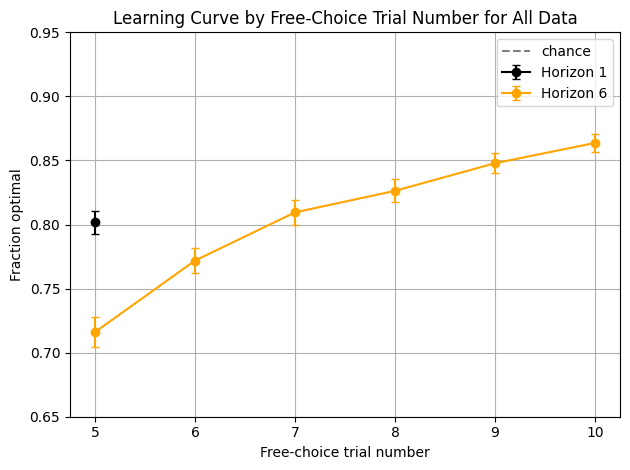

In [56]:
plot_trial_accuracy(free_trials, 'All Data', ylim=(0.65, 0.95))

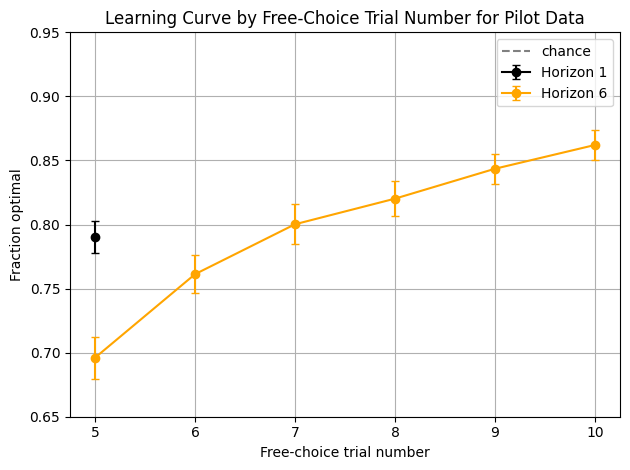

In [57]:
plot_trial_accuracy(pilot_free_df, 'Pilot Data', ylim=(0.65, 0.95))

### Model Data Loaded

In [58]:
def read_data_from_folder(folder_path):
    dfs = pd.DataFrame()
    file_count = 0  # counter for loaded files

    # Regex to extract the number after "participant_" and before ".csv"
    # This regex looks for "participant_" followed by one or more digits (\d+)
    # and captures these digits. It expects ".csv" at the end.
    participant_id_regex = re.compile(r'participant_(\d+)\.csv')


    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            # Extract model_id from filename using regex
            match = participant_id_regex.search(filename)
            if match:
                model_id = int(match.group(1)) # Convert the captured digits to an integer
                df['model_id'] = model_id # Add the model_id column
            else:
                # Handle cases where the filename doesn't match the expected format
                print(f"Warning: Could not extract model_id from filename: {filename}")
                df['model_id'] = None # Or some other indicator of missing ID

            dfs = pd.concat([dfs, df], ignore_index=True)
            file_count += 1  # increment counter

    print(f"{file_count} CSV file(s) loaded.")
    return dfs

In [59]:
centaur_df=read_data_from_folder(f'{PATH}/centaur-8B/singles')

31 CSV file(s) loaded.


In [60]:
centaur_df.rename(columns={'trial_num': 'trial', 'reward_mean_H': 'm1', 'reward_mean_I': 'm2'}, inplace=True)

In [61]:
rw_df=pd.read_csv('data/rw/rw_horizon_data.csv')

In [62]:
df_llama_8b=read_data_from_folder(f'{PATH}/llama-8B/singles')

31 CSV file(s) loaded.


In [63]:
df_llama_70b=read_data_from_folder(f'{PATH}/llama-70B/singles')

31 CSV file(s) loaded.


In [64]:
centaur_df_70b=read_data_from_folder(f'{PATH}/centaur-70B/singles')

31 CSV file(s) loaded.


In [65]:
rw_df.rename(columns={'trial_num_block': 'trial', 'reward_mean_H': 'm1', 'reward_mean_I': 'm2'}, inplace=True)
df_llama_8b.rename(columns={'trial_num': 'trial', 'reward_mean_H': 'm1', 'reward_mean_I': 'm2'}, inplace=True)
df_llama_70b.rename(columns={'trial_num': 'trial', 'reward_mean_H': 'm1', 'reward_mean_I': 'm2'}, inplace=True)
centaur_df_70b.rename(columns={'trial_num': 'trial', 'reward_mean_H': 'm1', 'reward_mean_I': 'm2'}, inplace=True)

In [66]:
centaur_df['choice']=centaur_df['choice'].map({'H':1,'I':2})
df_llama_8b['choice']=df_llama_8b['choice'].map({'H':1,'I':2})
df_llama_70b['choice']=df_llama_70b['choice'].map({'H':1,'I':2})
centaur_df_70b['choice']=centaur_df_70b['choice'].map({'H':1,'I':2})
rw_df['choice']=rw_df['choice'].map({'H':1,'I':2})

### Accuracy plot

In [67]:
def set_dynamic_fontsize(fig_width=12, base_font=20):
    scale = fig_width / 6  # 6 is your baseline width, adjust as needed
    plt.rcParams.update({
        'font.size': base_font * scale * 0.65,
        'axes.titlesize': base_font * scale * 1.2,
        'axes.labelsize': base_font * scale * 0.9,
        'xtick.labelsize': base_font * scale * 0.9,
        'ytick.labelsize': base_font * scale * 0.9,
        'legend.fontsize': base_font * scale,
    })

# Example: for a large figure

In [68]:
# prompt: i want function like plot trial accuracy that plots human_df as red and blue lines with alpha=0.3 and above centaur performance
def plot_trial_accuracy_with_centaur(human_df, centaur_df, title, ylim=(0.4, 1.0),label='Centaur',AZblue='black',AZred='orange'):
    """
    Plots the trial accuracy for human data and overlays centaur performance.

    Args:
        human_df (pd.DataFrame): DataFrame containing human data with 'trial',
                                 'horizon', and 'co' columns.
        centaur_df (pd.DataFrame): DataFrame containing centaur data with 'trial',
                                   'horizon', and 'co' columns.
        title (str): Title for the plot.
        ylim (tuple): Y-axis limits for the plot.
    """
    plt.figure(figsize=(16, 12))
    # Calculate accuracy for human data per horizon and trial
    human_h1 = human_df[human_df['horizon'] == 1]
    human_h6 = human_df[human_df['horizon'] == 6]
    accuracy_h1 = trial_accuracy(human_h1)
    accuracy_h6 = trial_accuracy(human_h6)

    # Plot human data
    plt.errorbar(
        accuracy_h1.index,
        accuracy_h1['accuracy'],
        yerr=accuracy_h1['se'],
        fmt='o', capsize=3, label='Horizon 1',
        color=AZblue
    )
    plt.errorbar(
        accuracy_h6.index,
        accuracy_h6['accuracy'],
        yerr=accuracy_h6['se'],
        fmt='o', capsize=3, label='Horizon 6',
        color=AZred
    )

    # Calculate accuracy for centaur data per horizon and trial
    centaur_h1 = centaur_df[centaur_df['horizon'] == 1]
    centaur_h6 = centaur_df[centaur_df['horizon'] == 6]
    accuracy_centaur_h1 = trial_accuracy(centaur_h1)
    accuracy_centaur_h6 = trial_accuracy(centaur_h6)

    # Plot centaur data
    plt.plot(
        accuracy_centaur_h1.index,
        accuracy_centaur_h1['accuracy'], linestyle='-', label=f'{label}(Horizon 1)',marker='s',
        color=AZblue,
        alpha=1
    )
    plt.plot(
        accuracy_centaur_h6.index,
        accuracy_centaur_h6['accuracy'],
        linestyle='-', label=f'{label}(Horizon 6)',
        color=AZred,
        alpha=1
    )

    plt.xlabel("free-choice trial number")
    plt.ylabel("accuracy (optimal choice rate)")
    plt.title(f"Learning Curve: {title}")
    plt.ylim(ylim)
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Assuming 'free_trials' contains the relevant human data
# and 'centaur_free_df' contains the relevant centaur data



In [69]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors_centaur_new =  ['#44403B','#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7','#009E73']

In [70]:
rw_df['co']=rw_df.apply(is_optimal_choice,axis=1)
df_llama_8b['co']=df_llama_8b.apply(is_optimal_choice,axis=1)
df_llama_70b['co']=df_llama_70b.apply(is_optimal_choice,axis=1)
centaur_df_70b['co']=centaur_df_70b.apply(is_optimal_choice,axis=1)
centaur_df['co']=centaur_df.apply(is_optimal_choice,axis=1)

In [71]:
rw_df_free=rw_df[rw_df['trial_type']=='free']

In [72]:
centaur_df_70b_free=centaur_df_70b[centaur_df_70b['is_free']==True]
centaur_free_df=centaur_df[centaur_df['is_free']==True]
llama_free=df_llama_8b[df_llama_8b['is_free']==True]
llama_70b_free=df_llama_70b[df_llama_70b['is_free']==True]

In [73]:
trial_accuracy(llama_free)

accuracy        se
trial                    
5      0.608871  0.003796
6      0.624798  0.006631
7      0.681250  0.006310
8      0.695161  0.004421
9      0.709073  0.004663
10     0.718347  0.004961

In [74]:
llama_free['co'].value_counts()

co
True     23046
False    11674
Name: count, dtype: int64

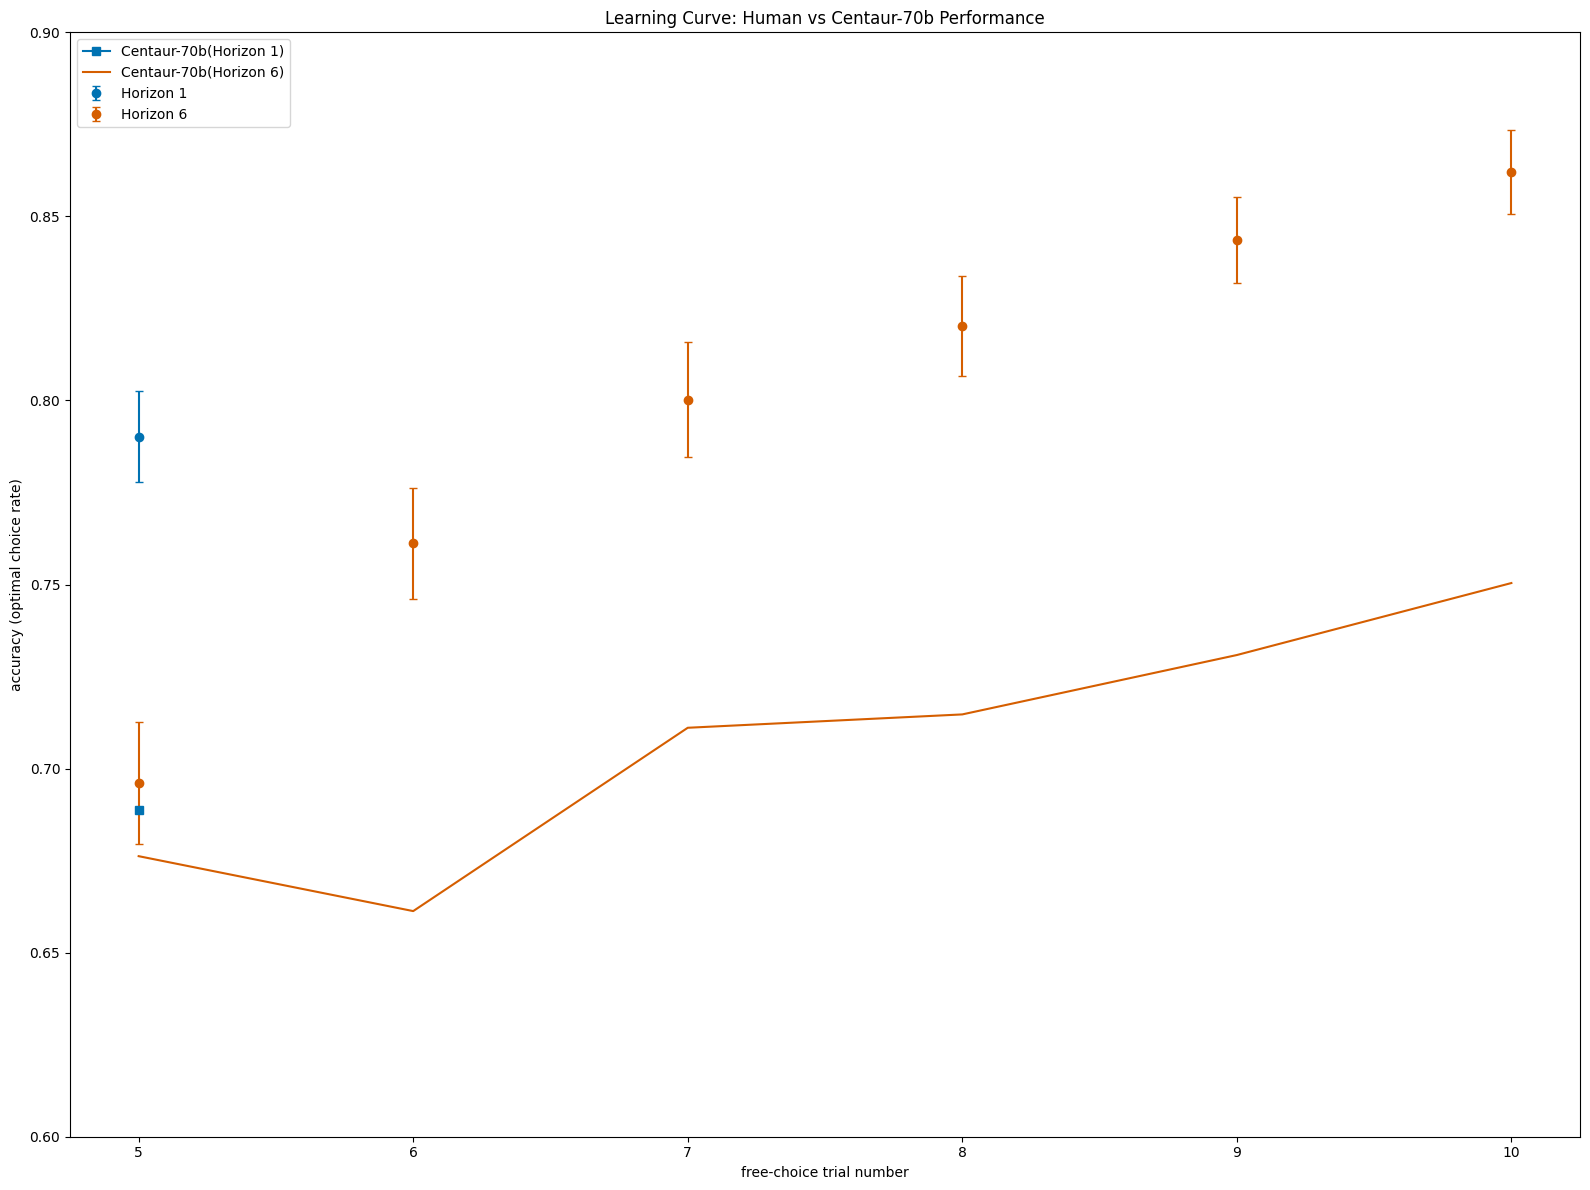

In [75]:
plot_trial_accuracy_with_centaur(pilot_free_df, centaur_df_70b_free, 'Human vs Centaur-70b Performance', ylim=(0.6, 0.9),AZblue=colors_centaur_new[4],AZred=colors_centaur_new[2],label='Centaur-70b')

In [76]:
set_dynamic_fontsize(fig_width=14, base_font=20)

In [77]:
def plot_trial_accuracy_with_centaur_margin(human_df, centaur_df, title, ylim=(0.4, 1.0)):
    """
    Plots the trial accuracy for Horizon 6 human data with error bars and overlays
    centaur performance with a standard error margin.

    Args:
        human_df (pd.DataFrame): Human data with 'trial', 'horizon', and 'co' columns.
        centaur_df (pd.DataFrame): Centaur data with 'trial', 'horizon', and 'co' columns.
        title (str): Plot title.
        ylim (tuple): Y-axis limits.
    """
    fig, ax = plt.subplots(figsize=(16, 12))

    # Filter and compute Horizon 6 only
    human_h6 = human_df[human_df['horizon'] == 6]
    accuracy_h6 = trial_accuracy(human_h6)

    ax.errorbar(
        accuracy_h6.index,
        accuracy_h6['accuracy'],
        yerr=accuracy_h6['se'],
        fmt='o-', capsize=3, label='Human Horizon 6',
        color='orange', alpha=0.7
    )

    centaur_h6 = centaur_df[centaur_df['horizon'] == 6]
    accuracy_centaur_h6 = trial_accuracy(centaur_h6)

    ax.plot(
        accuracy_centaur_h6.index,
        accuracy_centaur_h6['accuracy'],
        marker='x', linestyle='--', label='Centaur Horizon 6',
        color='orange'
    )
    ax.fill_between(
        accuracy_centaur_h6.index,
        accuracy_centaur_h6['accuracy'] - accuracy_centaur_h6['se'],
        accuracy_centaur_h6['accuracy'] + accuracy_centaur_h6['se'],
        color='orange', alpha=0.2
    )

    ax.set_xlabel("Free-choice trial number")
    ax.set_ylabel("Fraction optimal")
    ax.set_title(f"Learning Curve (Horizon 6): {title}")
    ax.set_ylim(ylim)
    ax.legend()
    ax.grid(False)
    fig.tight_layout()
    plt.show()


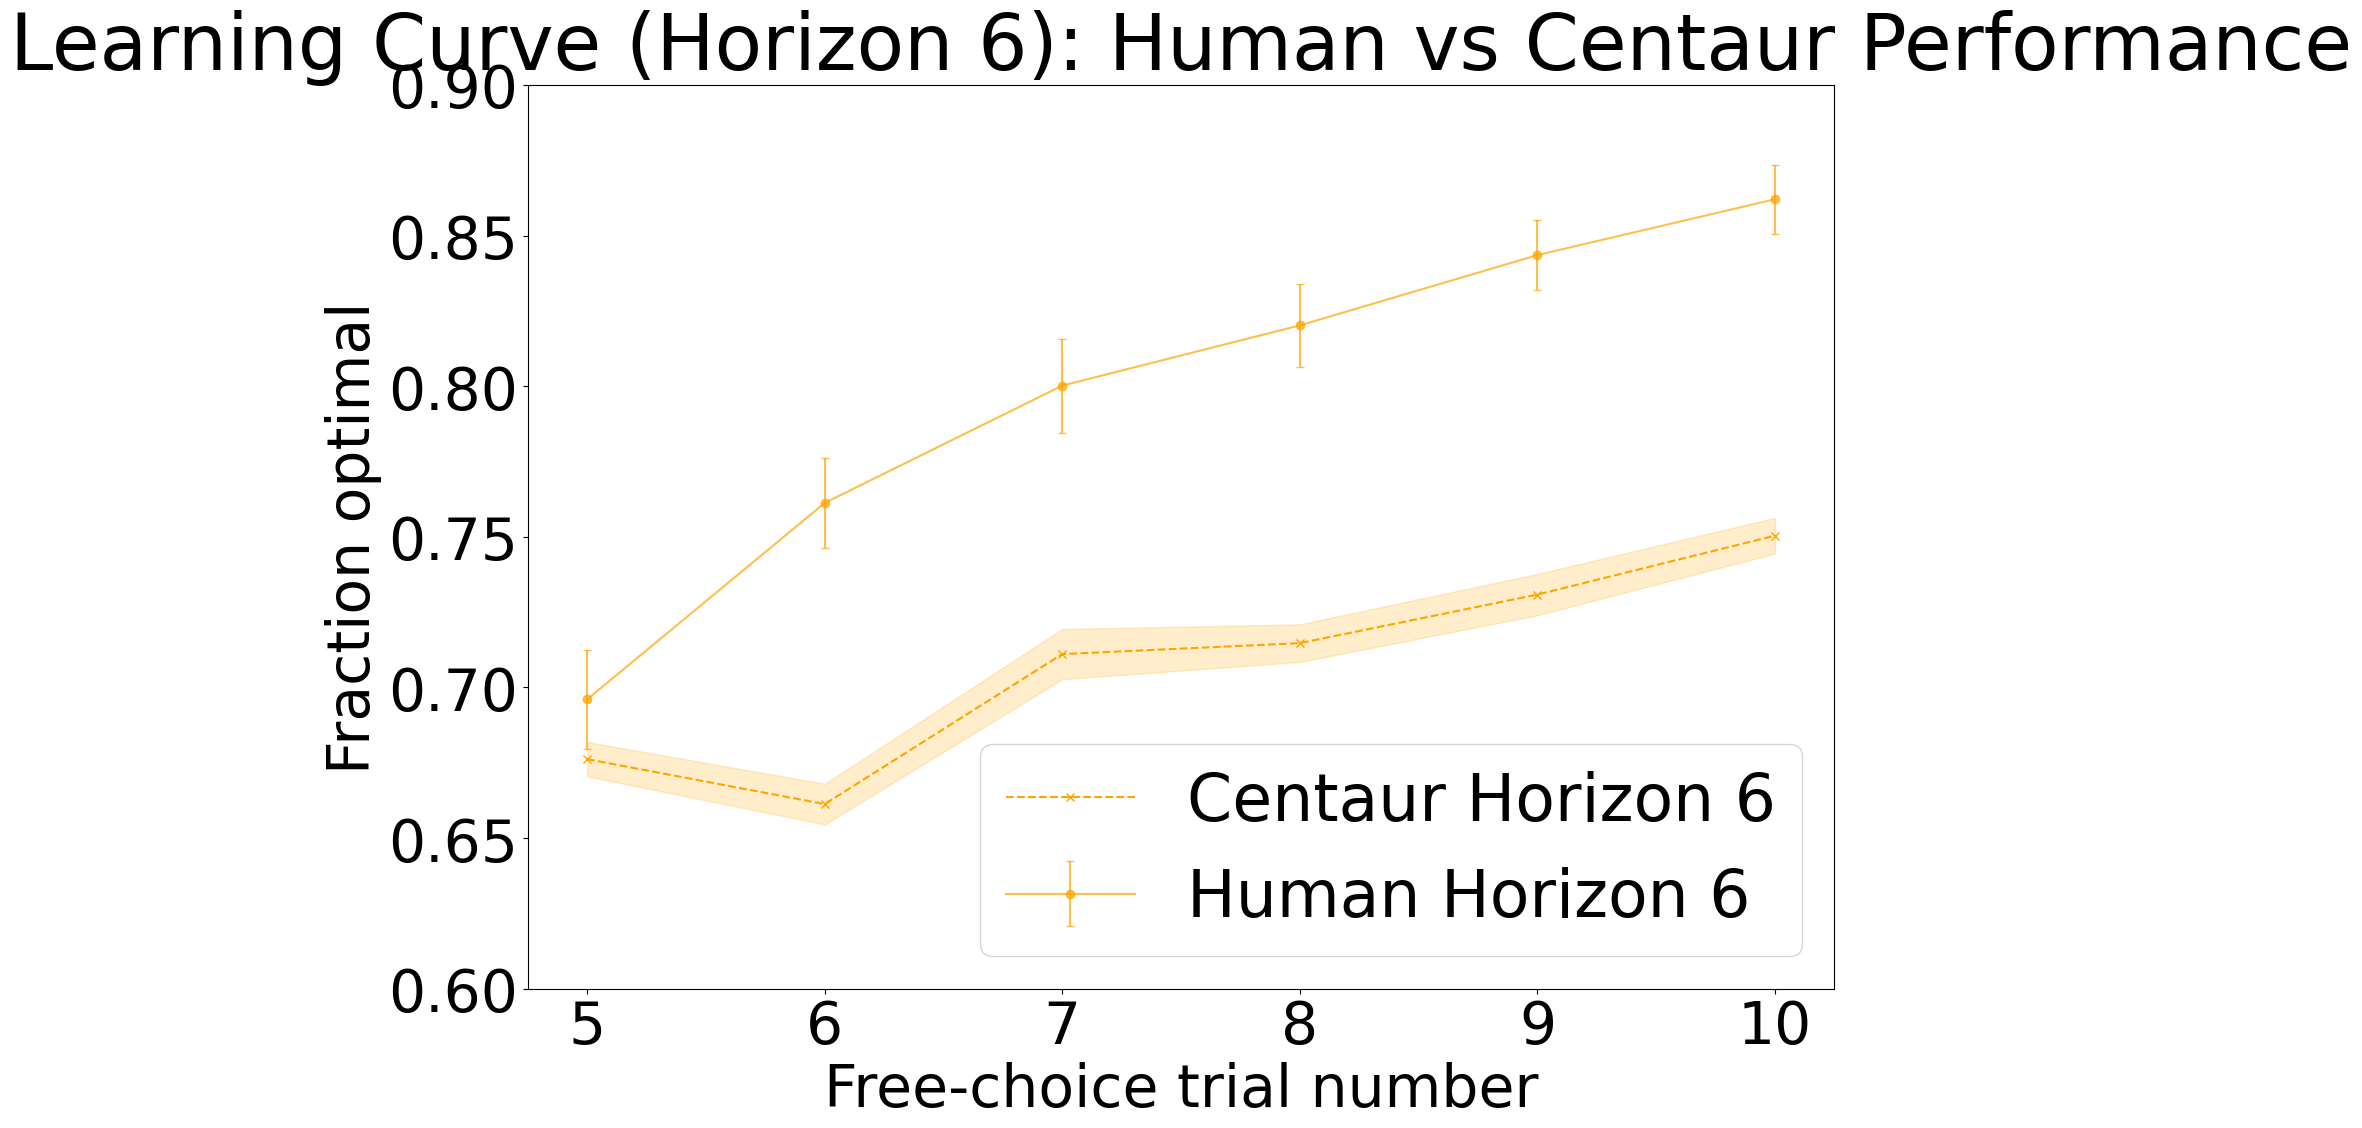

In [78]:
plot_trial_accuracy_with_centaur_margin(pilot_free_df, centaur_df_70b_free, 'Human vs Centaur Performance', ylim=(0.6, 0.9))

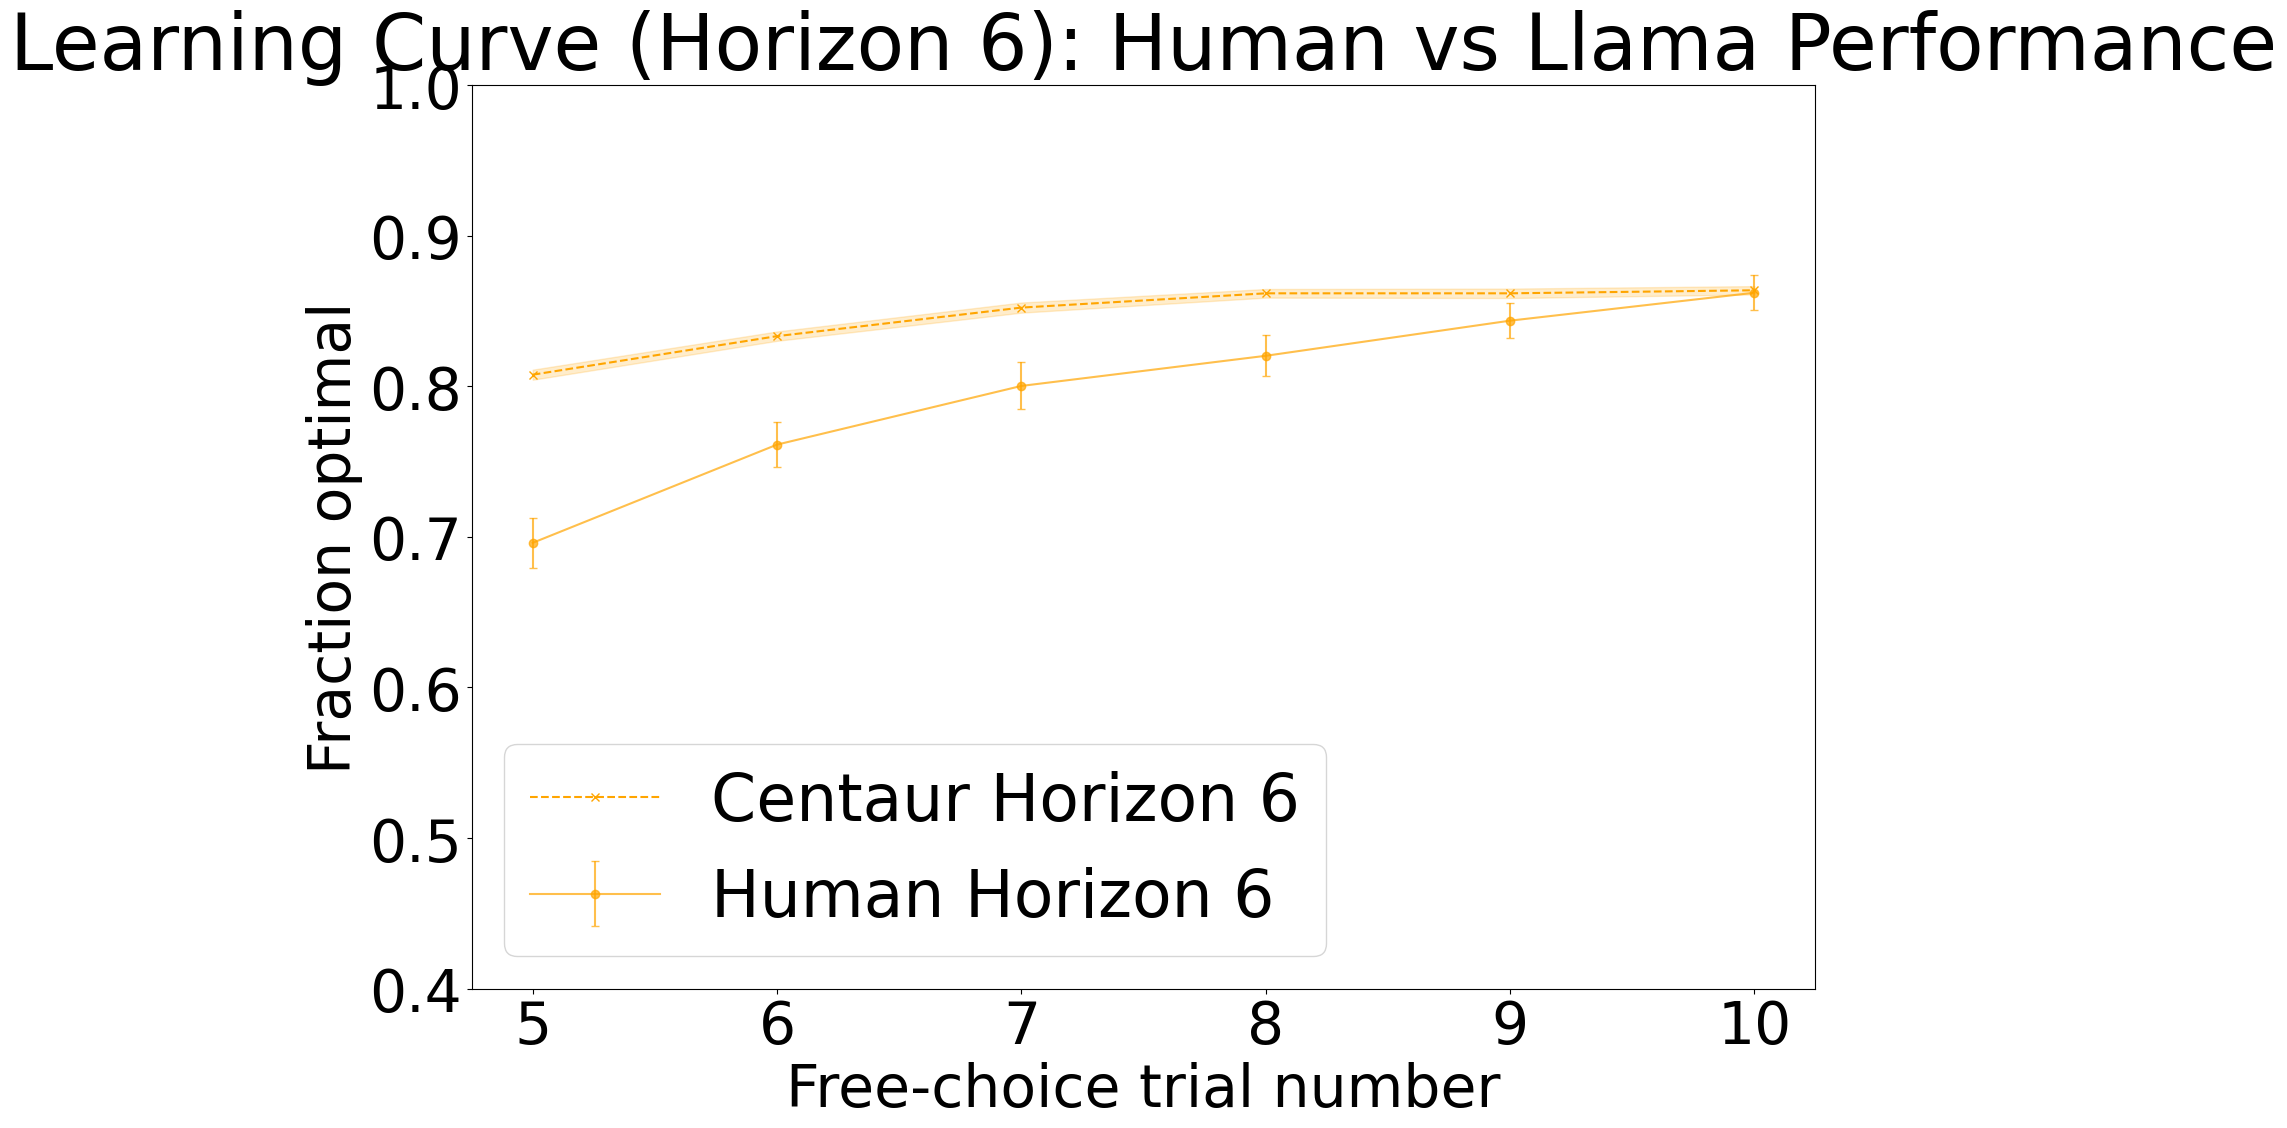

In [79]:
plot_trial_accuracy_with_centaur_margin(pilot_free_df, llama_70b_free, 'Human vs Llama Performance')

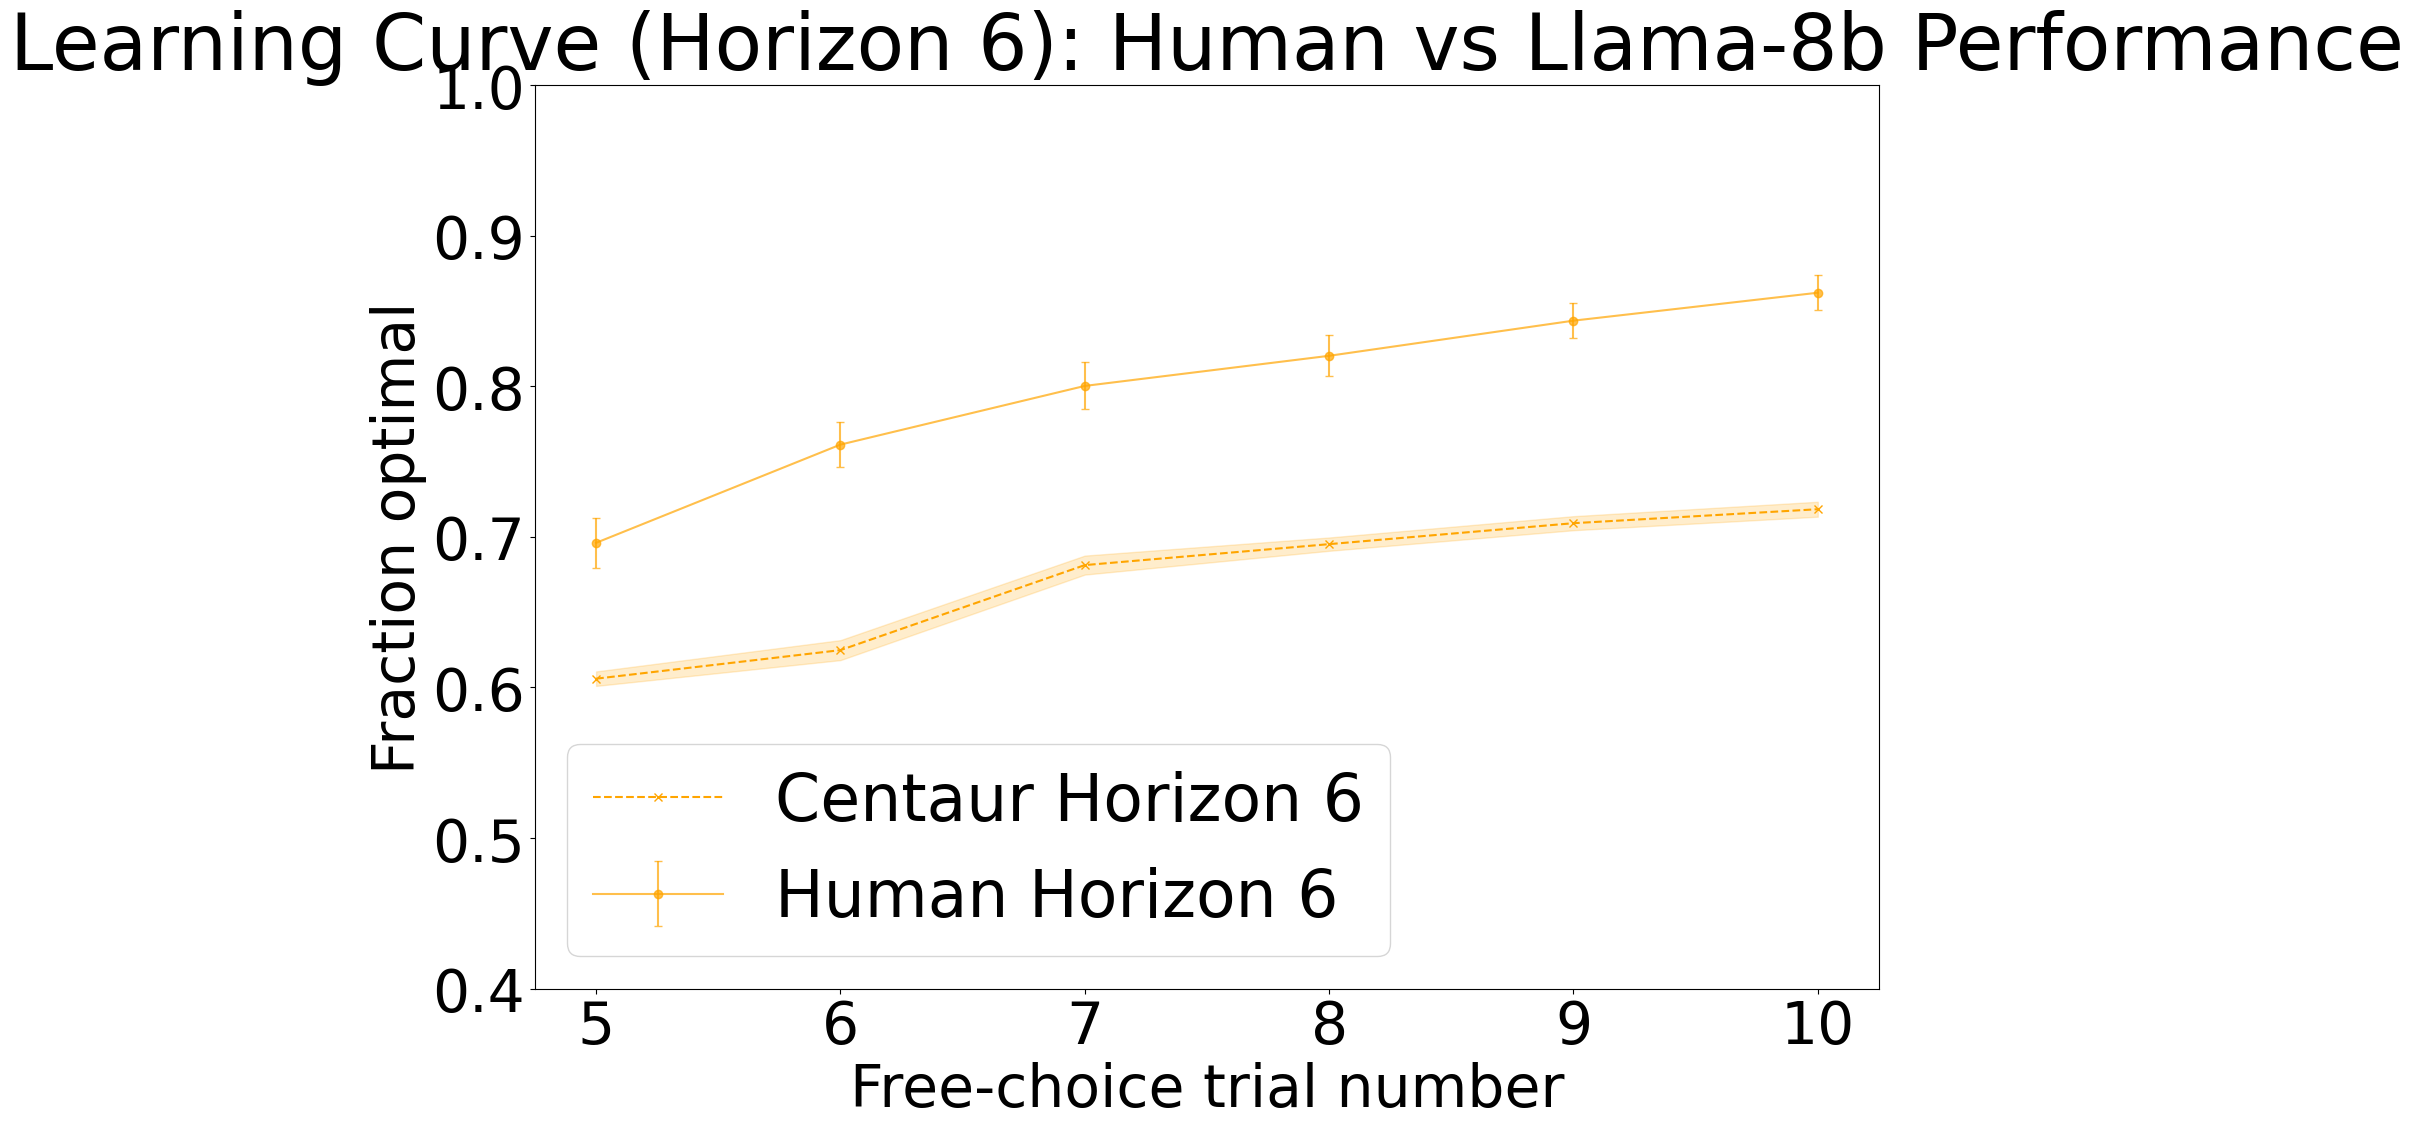

In [80]:
plot_trial_accuracy_with_centaur_margin(pilot_free_df, llama_free, 'Human vs Llama-8b Performance')

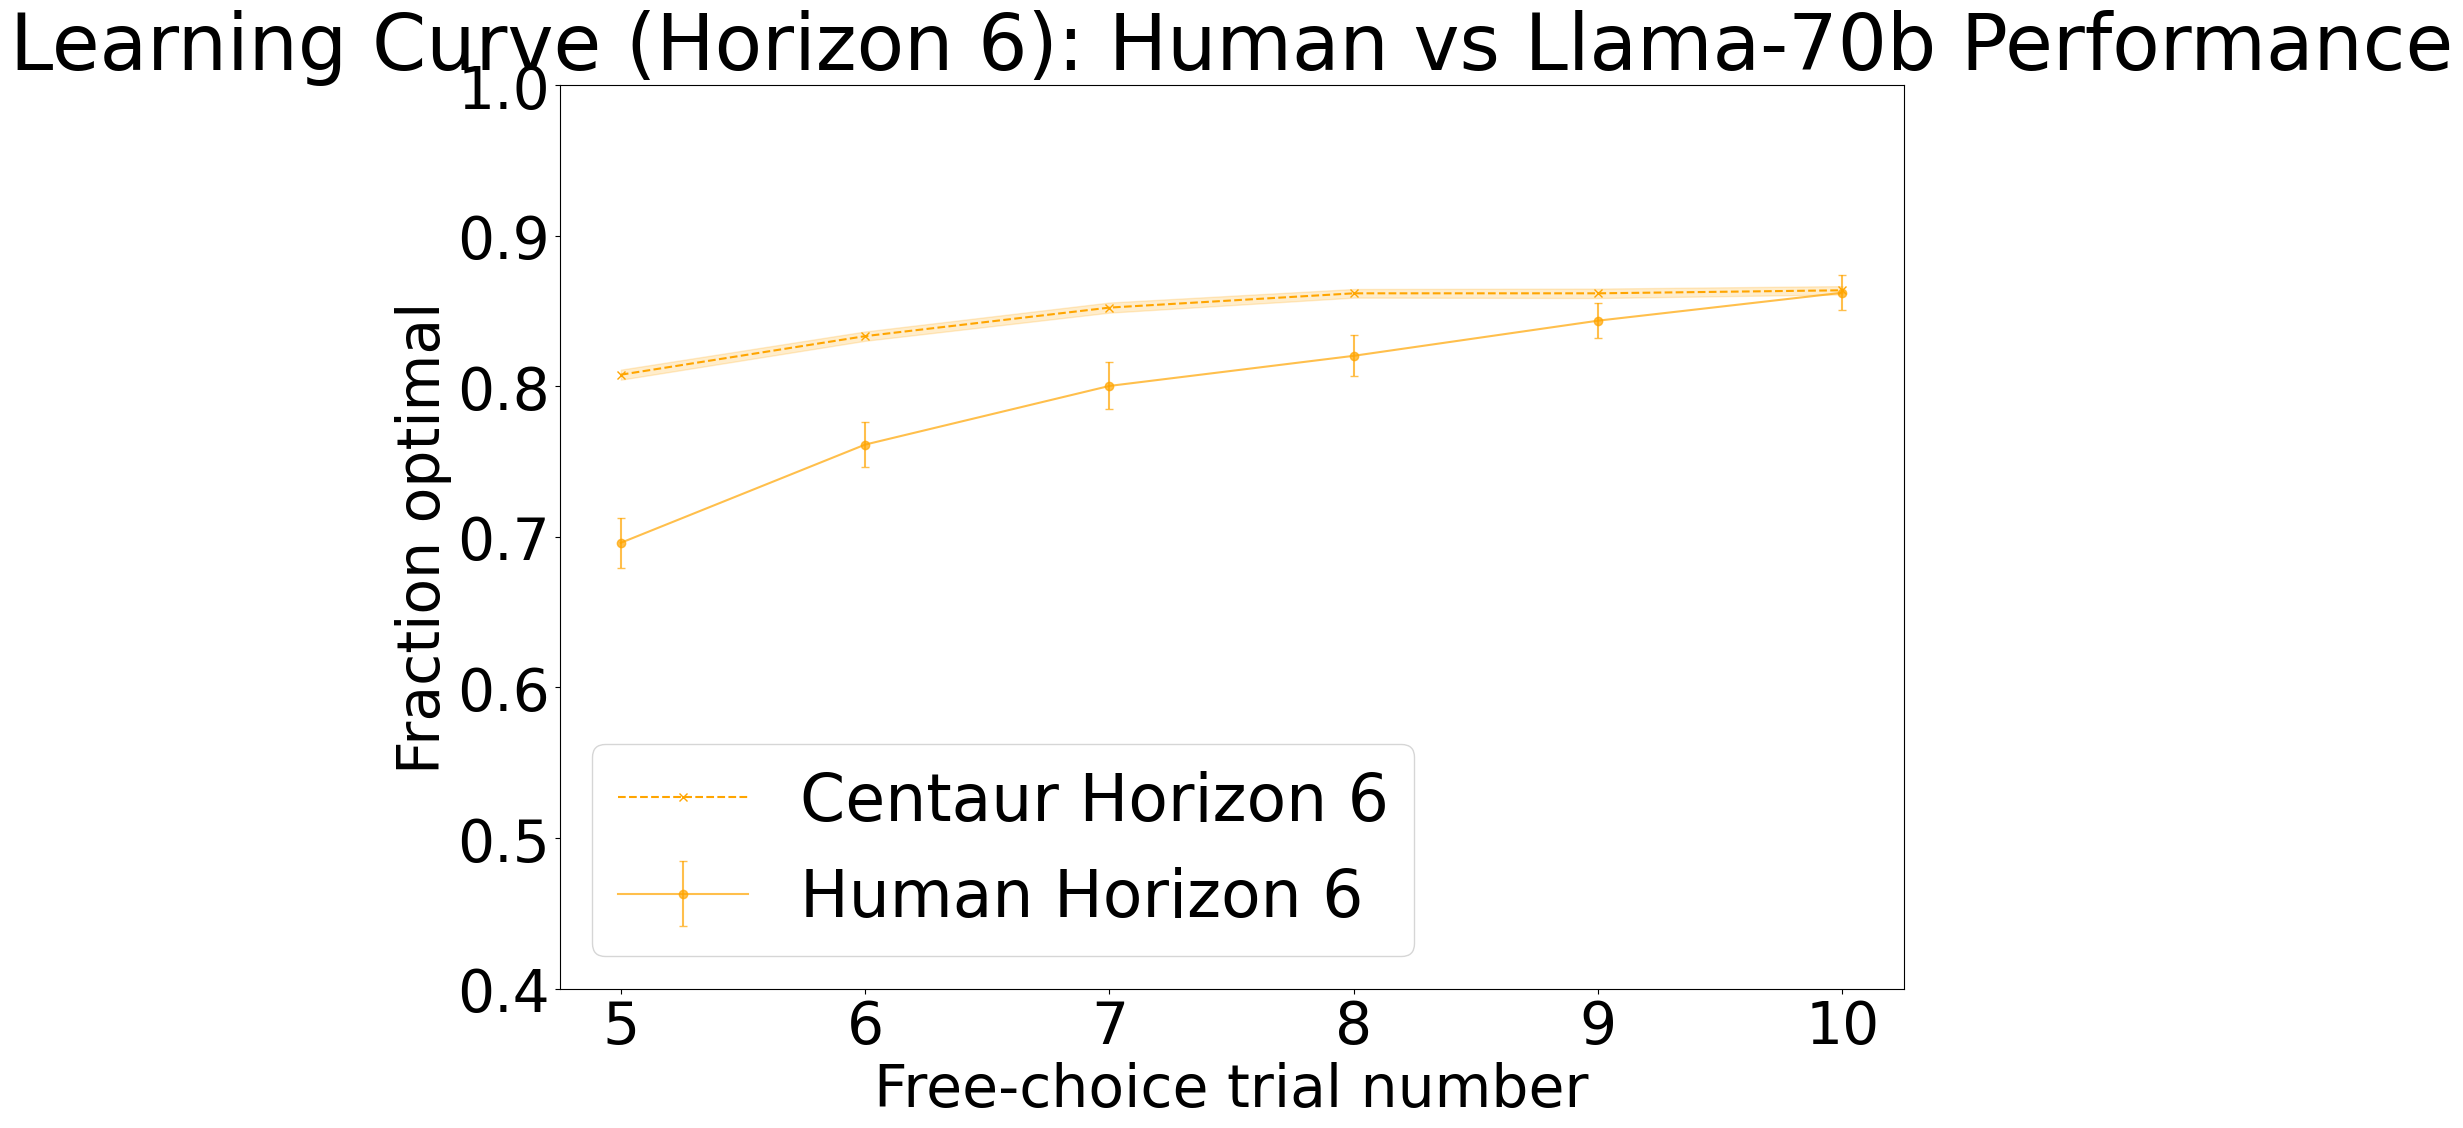

In [81]:
plot_trial_accuracy_with_centaur_margin(pilot_free_df, llama_70b_free, 'Human vs Llama-70b Performance')

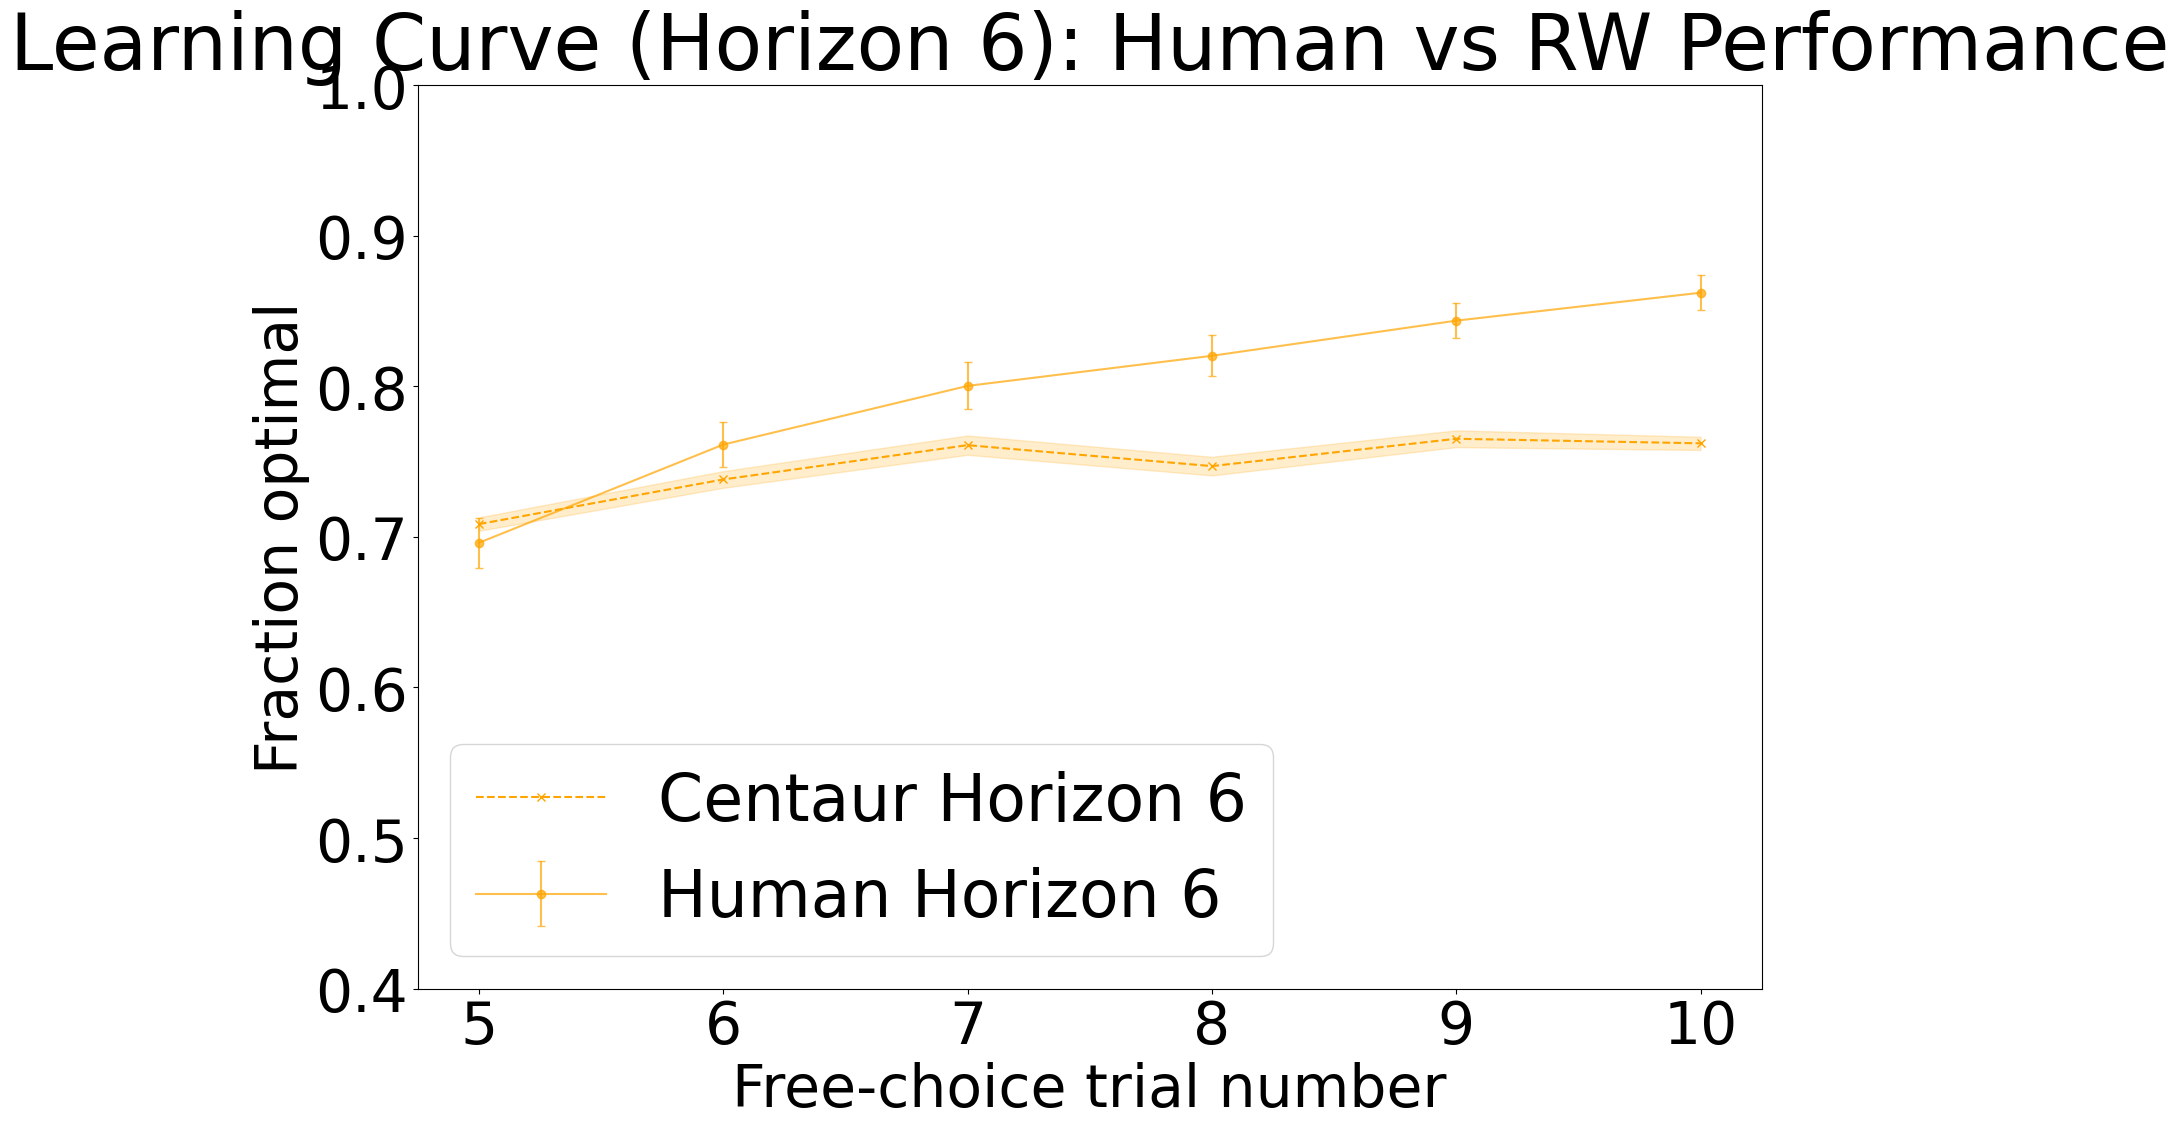

In [82]:
plot_trial_accuracy_with_centaur_margin(pilot_free_df, rw_df_free, 'Human vs RW Performance')

In [83]:
class HandlerLineWithFill(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        center_y = y0 + height / 2
        fill_height = height * 0.8  # Increase fill height (was 0.5 before)

        # Shaded fill (larger vertical margin)
        patch = Rectangle((x0, center_y - fill_height / 2), width, fill_height,
                          facecolor=orig_handle.get_facecolor(), edgecolor='none', alpha=0.3,
                          transform=trans)

        # Line across the center
        line = Line2D([x0, x0 + width], [center_y, center_y],
                      linestyle='-', color=orig_handle.get_edgecolor(), linewidth=2,
                      transform=trans)

        return [patch, line]

class HandlerErrorbar(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        center_x = x0 + width / 2
        center_y = y0 + height / 2

        # Marker
        marker = Line2D([center_x], [center_y], marker='s', color=orig_handle.get_color(),
                        markersize=8, linestyle='None', transform=trans)

        # Vertical error bar
        err_line = Line2D([center_x, center_x], [center_y - height/2, center_y + height/2],
                          color=orig_handle.get_color(), linestyle='-', linewidth=1.5, transform=trans)

        return [err_line, marker]


In [84]:
def plot_trial_accuracy_with_multiple_centaur_models(human_df, centaur_dfs=None, labels=None,
                                                      title=None, ylim=(0.4, 1.0),
                                                      centaur_colors=None,
                                                      yticks=None):
    """
    Plots human trial accuracy for Horizon 6 with overlay of multiple Centaur models.

    Args:
        human_df (pd.DataFrame): Human data with 'trial', 'horizon', and 'co' columns.
        centaur_dfs (list of pd.DataFrame): List of Centaur model DataFrames.
        labels (list of str): List of labels for each Centaur model.
        title (str): Title of the plot.
        ylim (tuple): Y-axis range.
        AZred (str): Color for Human Horizon 6.
        centaur_colors (list of str): List of colors for Centaur models.
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    bar_w = 0.25


    human_h1 = human_df[human_df['horizon'] == 1]
    acc_h1 = trial_accuracy(human_h1)
    ax.errorbar(range(1, len(acc_h1) + 1), acc_h1['accuracy'], yerr=acc_h1['se'], capsize=10, markersize=15,
                 fmt='s', label='Human',
                                 color=centaur_colors[0], alpha=0.5, zorder=1)

    # --- Human Data: Horizon 6 ---
    human_h6 = human_df[human_df['horizon'] == 6]
    acc_h6 = trial_accuracy(human_h6)
    ax.plot(range(1, len(acc_h6) + 1), acc_h6['accuracy'], linestyle='-',
                 color=centaur_colors[0], alpha=0.5, zorder=1)
    ax.fill_between(range(1, len(acc_h6) + 1),
                         acc_h6['accuracy'] - acc_h6['se'],
                         acc_h6['accuracy'] + acc_h6['se'],
                         color=centaur_colors[0], alpha=0.1)

    # --- Centaur Models ---
    if centaur_colors is None:
        from matplotlib.cm import get_cmap
        cmap = get_cmap('tab10')
        centaur_colors = [cmap(i) for i in range(len(centaur_dfs))]
    if centaur_dfs is not None:

        for df, label, color in zip(centaur_dfs, labels, centaur_colors[1:]):
            df_h1 = df[df['horizon'] == 1]
            acc_h1 = trial_accuracy(df_h1)
            df_h6 = df[df['horizon'] == 6]
            acc_h6 = trial_accuracy(df_h6)
            #print(acc_h6)
            ax.plot(range(1, len(acc_h6) + 1), acc_h6['accuracy'], linestyle='-',
                    color=color, alpha=1, label=f'{label}', zorder=2)
            ax.fill_between(range(1, len(acc_h6) + 1),
                            acc_h6['accuracy'] - acc_h6['se'],
                            acc_h6['accuracy'] + acc_h6['se'],
                            color=color, alpha=0.2)
            ax.errorbar(range(1, len(acc_h1) + 1), acc_h1['accuracy'],yerr=acc_h1['se'],marker='s', capsize=15, markersize=10,
                    color=color, alpha=1, label=f'{label}', zorder=2)

    # --- Plot Decoration ---
    ax.set_xlabel("Free-choice Trial",labelpad=10)
    ax.set_ylabel("Accuracy (Optimal Choice Rate)")
    if yticks is not None:
        ax.set_yticks(yticks)
    #ax.set_title(f"{title}")
    ax.set_ylim(ylim)
    transform=ax.get_xaxis_transform()
    ax.tick_params(axis='x', which='major', pad=15)
    #plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
    # Horizon 6 line with shaded margin

    # Collect handles and labels from actual plotted models
    handles, labels_legend = ax.get_legend_handles_labels()

    legend_fig = plt.figure(figsize=(6, 2))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis("off")
    legend_ax.legend(handles, labels_legend, loc='center', frameon=False,
                    )

    ax.margins(x=0.04)

    #plt.tight_layout()
    # plt.show() # Remove plt.show() here
    return fig, legend_fig

### Accuracy main plot

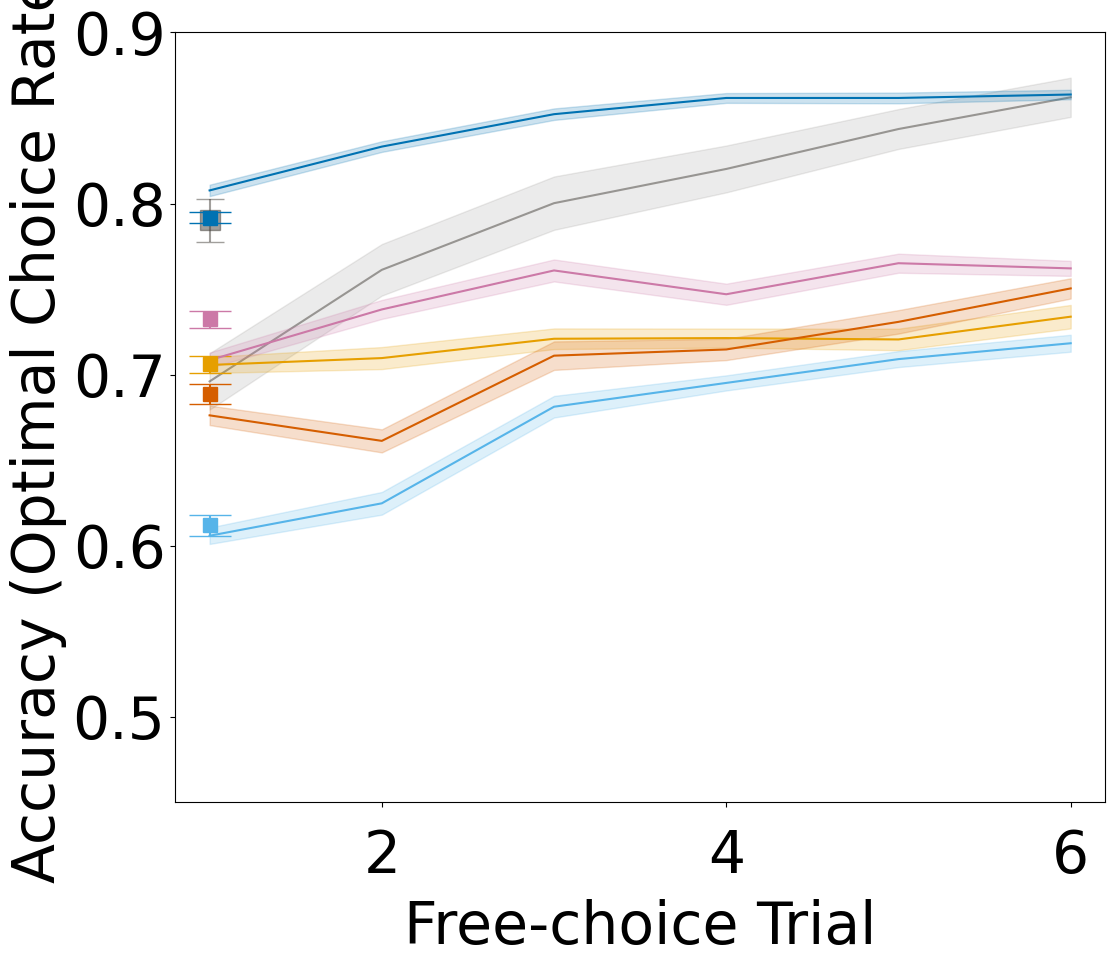

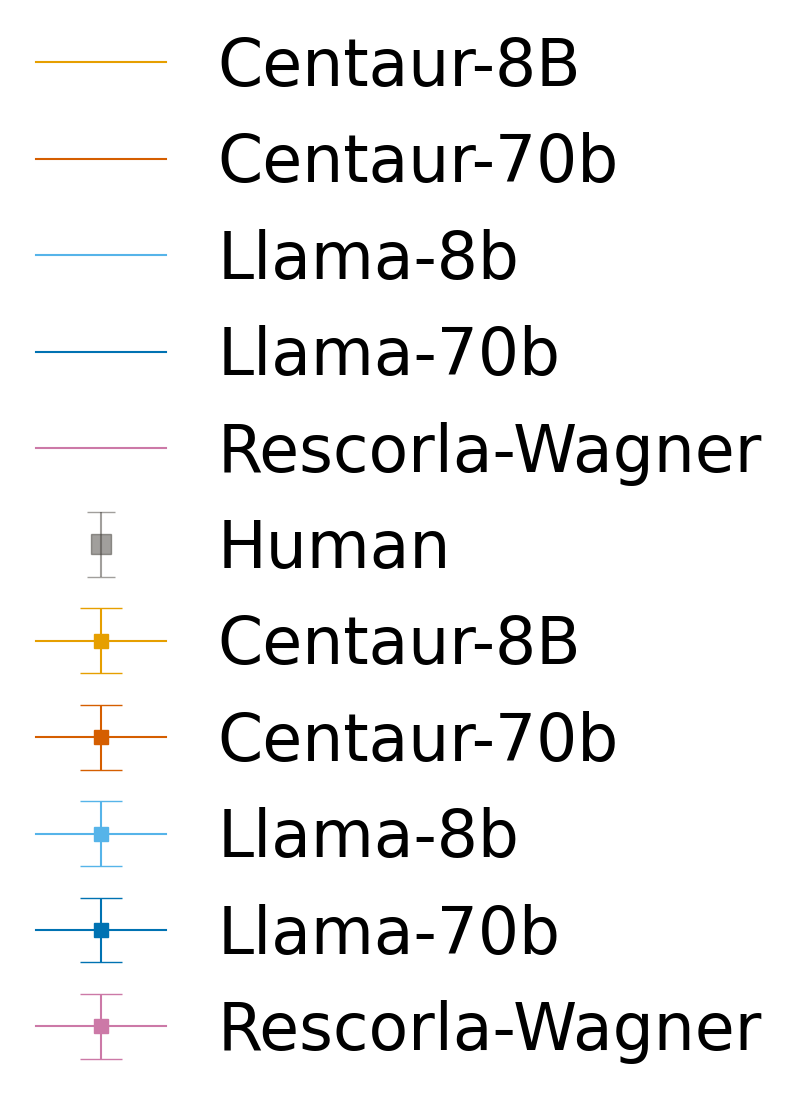

In [85]:
learning_curve,learning_curve_legend=plot_trial_accuracy_with_multiple_centaur_models(
    human_df=pilot_free_df,
    centaur_dfs=[centaur_free_df,centaur_df_70b_free,llama_free,llama_70b_free,rw_df_free],
    labels=['Centaur-8B','Centaur-70b','Llama-8b','Llama-70b','Rescorla-Wagner'],
    title='Generative Performance',
    centaur_colors=colors_centaur_new,
    ylim=(0.45, 0.9)
)


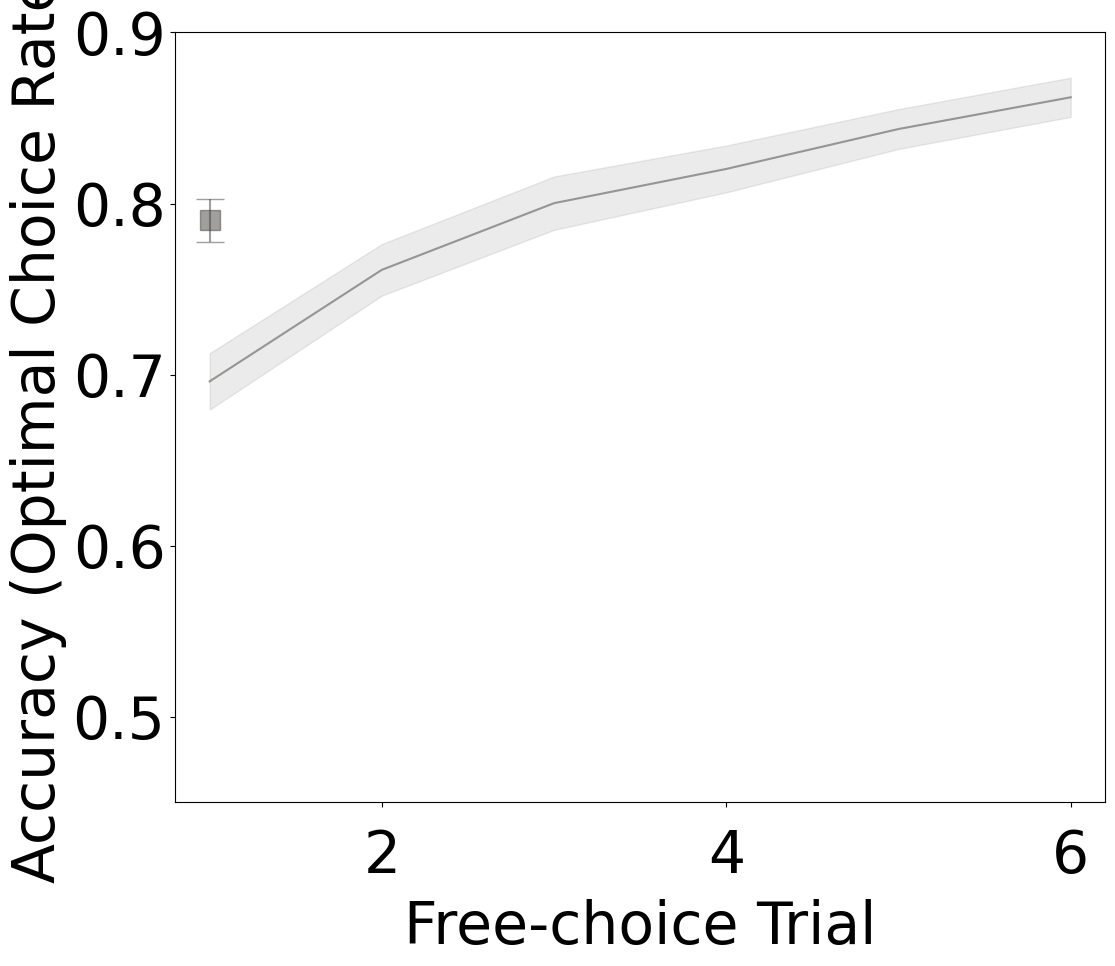

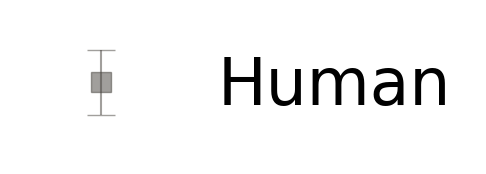

In [86]:
learning_curve_human,learning_curve_legend=plot_trial_accuracy_with_multiple_centaur_models(
    human_df=pilot_free_df,
    title='Generative Performance',
    centaur_colors=colors_centaur_new,
    ylim=(0.45, 0.9)
)


In [87]:
colors_large_models_only= ['black','#D55E00', '#0072B2', '#CC79A7','#009E73']

In [88]:
yticks = np.arange(0.6, 1.0, 0.1)

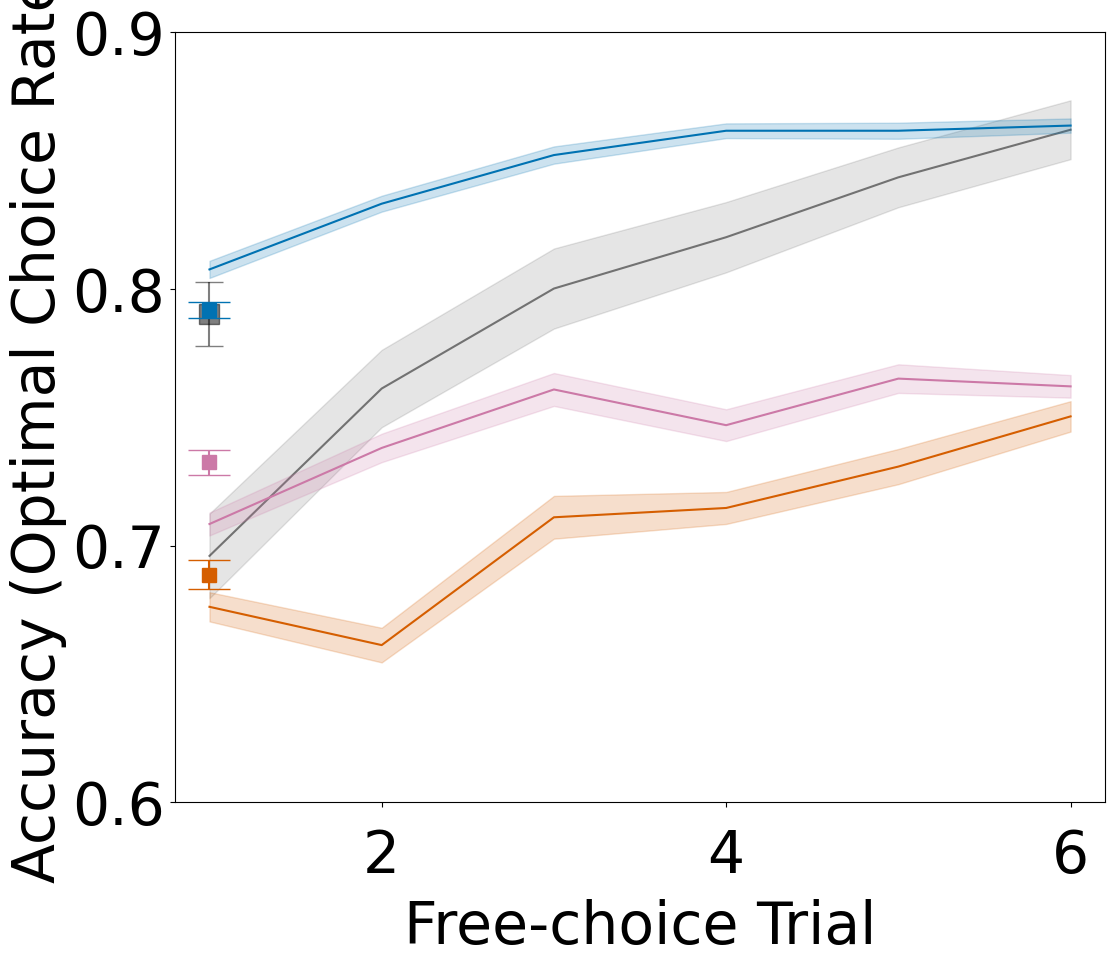

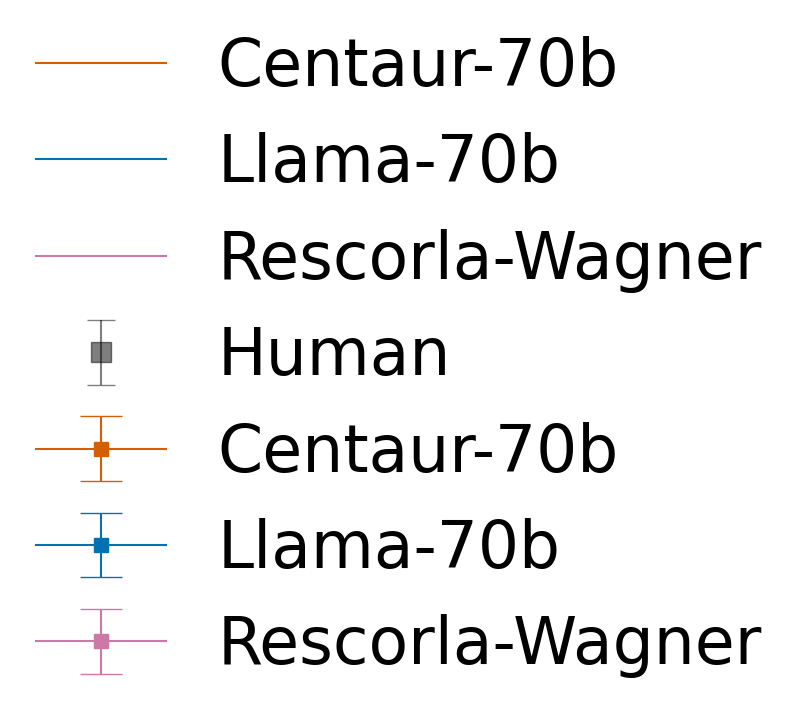

In [89]:
learning_curve_large,learning_curve_legend=plot_trial_accuracy_with_multiple_centaur_models(
    human_df=pilot_free_df,
    centaur_dfs=[centaur_df_70b_free,llama_70b_free,rw_df_free],
    labels=['Centaur-70b','Llama-70b','Rescorla-Wagner'],
    title='Generative Performance',
    centaur_colors=colors_large_models_only,
    ylim=(0.6, 0.9),
    yticks=yticks
)


In [90]:
def plot_fifth_trial_accuracy_bar(dfs, labels=None, colors=None,
                                   family_labels=None, family_slices=None,
                                   title="Accuracy on Trial 5 (Horizon 1 vs 6)"):
    n = len(dfs)
    w = 0.5  # bar width
    gap_in  = 0.05
    gap_out = 0.5

    xpos = []
    current_pos = 0
    for i in range(n):
        xpos.append(current_pos)
        if i in [0, 2, 4]:
            current_pos += w*2 + gap_out
        else:
            current_pos += w*2 + gap_in

    acc_h1_vals, acc_h1_se = [], []
    acc_h6_vals, acc_h6_se = [], []

    for df in dfs:
        h1 = df[(df['horizon'] == 1) & (df['trial'] == 5)]
        h6 = df[(df['horizon'] == 6) & (df['trial'] == 5)]
        acc_h1_vals.append(h1['co'].mean())
        acc_h1_se.append(h1['co'].std() / np.sqrt(len(h1)))
        acc_h6_vals.append(h6['co'].mean())
        acc_h6_se.append(h6['co'].std() / np.sqrt(len(h6)))

    fig, ax = plt.subplots(figsize=(12, 10))

    xpos = np.array(xpos)

    ax.bar(xpos - w/2, acc_h1_vals, w, yerr=acc_h1_se,
           label='Horizon 1', color=colors, hatch='//', capsize=5, alpha=0.6)
    ax.bar(xpos + w/2, acc_h6_vals, w, yerr=acc_h6_se,
           label='Horizon 6', color=colors, capsize=5)

    ax.set_ylabel('Accuracy (Optimal Choice Rate)')
    ax.set_ylim(0, 1.05)
    #ax.set_title(title, pad=20)
    ax.set_xticks(xpos)
    ax.set_xticklabels(labels)
    for i, family_slice in enumerate(family_slices):
        if isinstance(family_slice, tuple):
            i0, i1 = family_slice
            center = ((xpos[i0] + xpos[i1]) / 2)
        else:
            center = xpos[family_slice]
        ax.text(center, -0.10, family_labels[i],
                ha='center', va='top',
                transform=ax.get_xaxis_transform(),
                fontsize=28)

    # Visual group dividers
    for i, family_slice in enumerate(family_slices[:-1]):
        if isinstance(family_slice, tuple):
            i0, i1 = family_slice
            ax.axvline(xpos[i1] + w/2 + gap_out/2, color='grey', lw=1)
        else:
            ax.axvline(xpos[family_slice] + w/2 + gap_out/2, color='grey', lw=1)
    ax.legend()
    plt.tight_layout()
    return fig


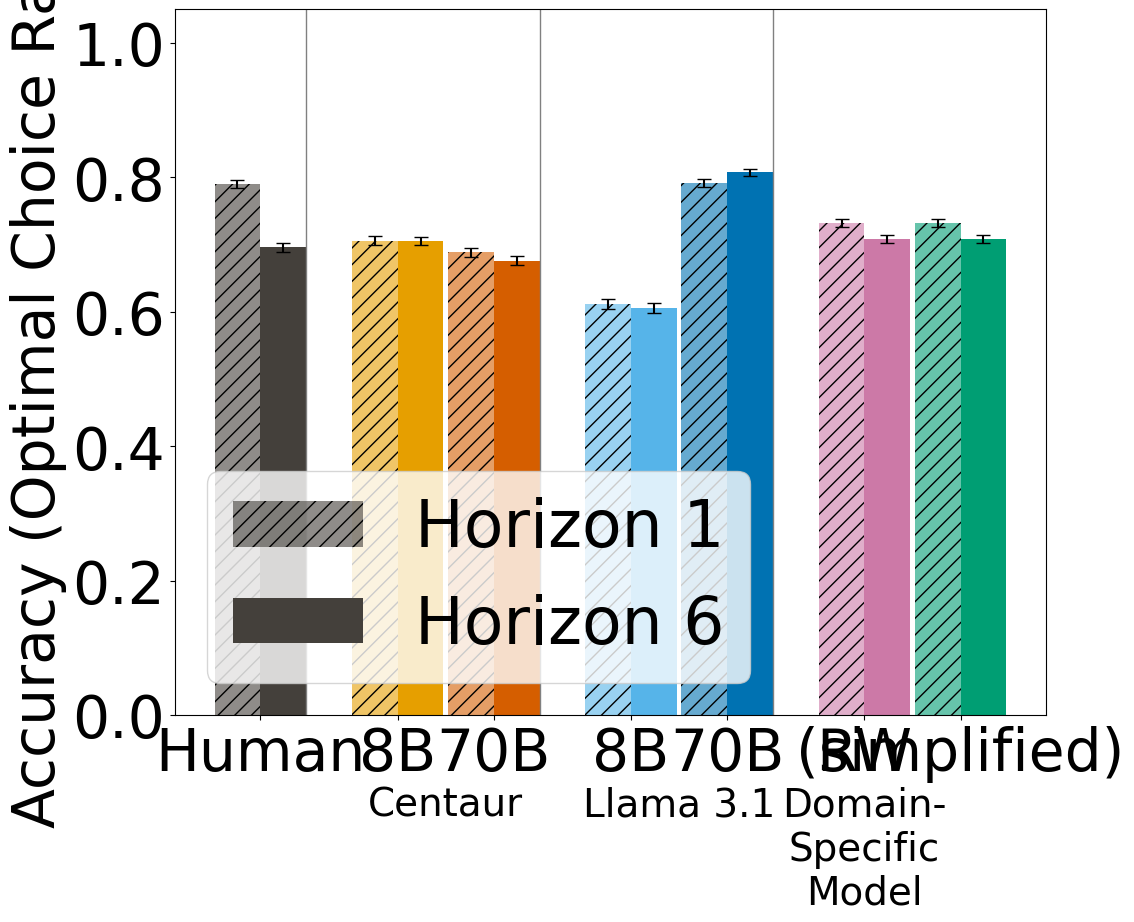

In [91]:
bar_horizon_1=plot_fifth_trial_accuracy_bar(
    dfs=[pilot_free_df,centaur_free_df,centaur_df_70b_free,llama_free,llama_70b_free,rw_df_free,rw_df_free],
    labels=['Human','8B', '70B', '8B', '70B', 'RW','(simplified)'],
    colors=colors_centaur_new,
    family_labels=['','Centaur', 'Llama 3.1', 'Domain-\nSpecific\nModel'],
    family_slices=[(0, 0), (1, 2), (3, 4), (5, 5)]
)

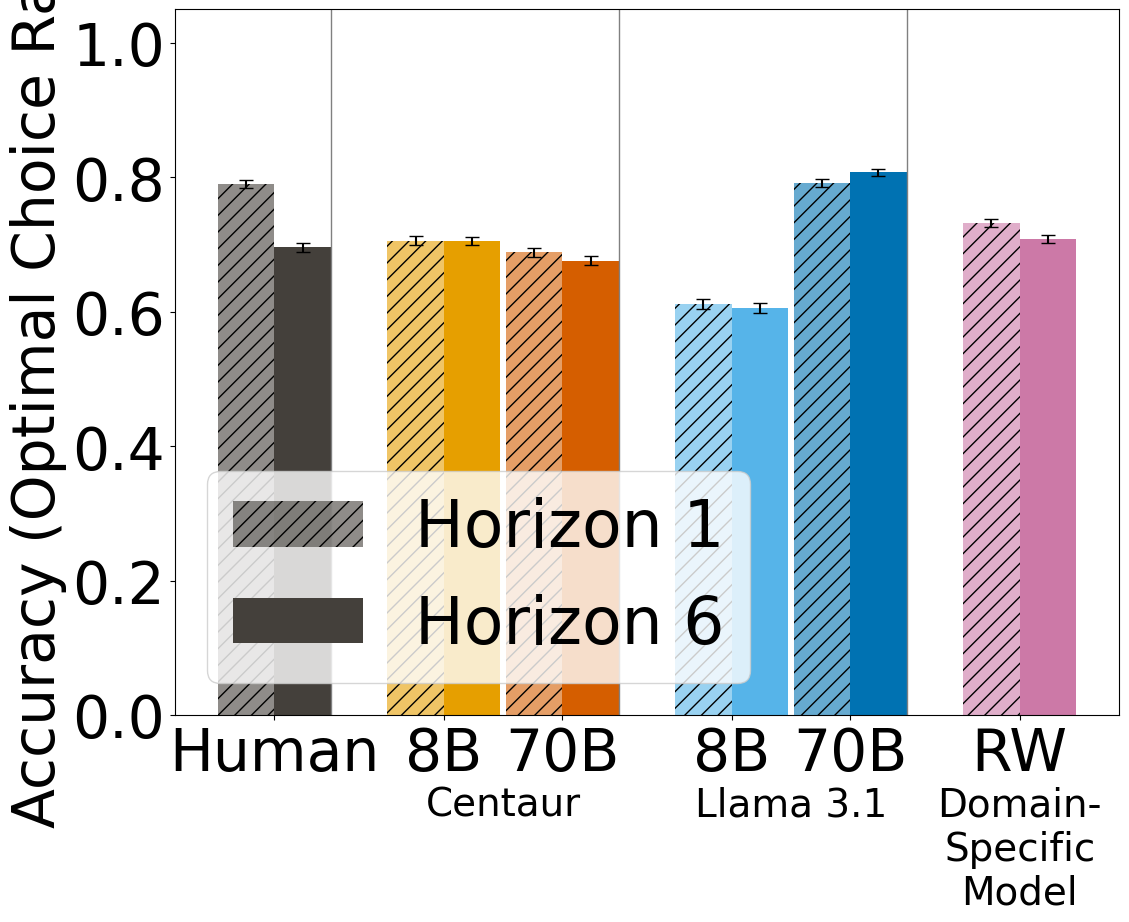

In [92]:
bar_horizon_1=plot_fifth_trial_accuracy_bar(
    dfs=[pilot_free_df,centaur_free_df,centaur_df_70b_free,llama_free,llama_70b_free,rw_df_free],
    labels=['Human','8B', '70B', '8B', '70B', 'RW'],
    colors=colors_centaur_new,
    family_labels=['','Centaur', 'Llama 3.1', 'Domain-\nSpecific\nModel'],
    family_slices=[(0, 0), (1, 2), (3, 4), (5, 5)]
)

In [93]:
accuracy_per_horizon_and_subject(centaur_free_df)

horizon  participant_id        co
0         1               1  0.712500
1         1               2  0.693750
2         1               3  0.743750
3         1               4  0.706250
4         1               5  0.731250
..      ...             ...       ...
57        6              27  0.704167
58        6              28  0.725000
59        6              29  0.727083
60        6              30  0.717708
61        6              31  0.718750

[62 rows x 3 columns]

In [94]:
trial_accuracy_centaur=trial_accuracy(centaur_free_df)
trial_accuracy_centaur

accuracy        se
trial                    
5      0.705847  0.003836
6      0.709677  0.006441
7      0.720968  0.006035
8      0.721371  0.005573
9      0.720565  0.006305
10     0.733871  0.006857

In [95]:
trial_accuracy_pilot=trial_accuracy(pilot_free_df)
trial_accuracy_pilot

accuracy        se
trial                    
5      0.743125  0.012770
6      0.761250  0.015074
7      0.800208  0.015598
8      0.820208  0.013695
9      0.843542  0.011654
10     0.862083  0.011466

<h3>plot 2</h3>

### plot fig 2c

In [97]:
def reshape_centaur_df(centaur_df):
    """
    Reshapes the centaur DataFrame from long to wide format.

    Args:
        centaur_df (pd.DataFrame): The input DataFrame in long format.

    Returns:
        pd.DataFrame: The reshaped DataFrame in wide format.
    """
    # Ensure trials are ordered
    centaur_df_wide = centaur_df.sort_values(by=['participant_id', 'block', 'game', 'trial'])

    # Add subjectNumber if needed
    centaur_df_wide['subjectNumber'] = centaur_df_wide['participant_id']

    # Create a unique game ID if needed
    centaur_df_wide['gID'] = centaur_df_wide.groupby(['participant_id', 'block', 'game']).ngroup()

    # Pivot to wide format for choices and rewards
    choice_wide = centaur_df_wide.pivot_table(index=['participant_id', 'subjectNumber', 'block', 'game'],
                                  columns='trial', values='choice', aggfunc='first')
    choice_wide.columns = [f'c{int(c)}' for c in choice_wide.columns]

    reward_wide = centaur_df_wide.pivot_table(index=['participant_id', 'subjectNumber', 'block', 'game'],
                                  columns='trial', values='reward', aggfunc='first')
    reward_wide.columns = [f'r{int(c)}' for c in reward_wide.columns]

    # Keep one row per game with game-level variables
    game_info = centaur_df_wide.groupby(['participant_id', 'subjectNumber', 'block', 'game'], as_index=False).first()
    cols_keep = ['participant_id', 'subjectNumber', 'block', 'game', 'horizon', 'info_condition', 'm1', 'm2', 'gID']
    game_info = game_info[cols_keep]

    # Merge with wide trial data
    centaur_df_reshaped = game_info.merge(choice_wide, on=['participant_id', 'subjectNumber', 'block', 'game'])
    centaur_df_reshaped = centaur_df_reshaped.merge(reward_wide, on=['participant_id', 'subjectNumber', 'block', 'game'])

    # Rename columns to match df_2
    centaur_df_reshaped = centaur_df_reshaped.rename(columns={
        'participant_id': 'subjectID',
        'horizon': 'gameLength',
        'info_condition': 'uc'
    })

    # Reorder columns to match df_2
    cols_order = ['subjectID', 'subjectNumber', 'block', 'game', 'gameLength', 'uc', 'm1', 'm2', 'gID'] + \
                 [f'r{i}' for i in range(1, 11)] + [f'c{i}' for i in range(1, 11)]

    centaur_df_reshaped = centaur_df_reshaped[cols_order]

    return centaur_df_reshaped

In [98]:
centaur_df_reshaped=reshape_centaur_df(centaur_df)

In [99]:
centaur_df_70b_reshaped = reshape_centaur_df(centaur_df_70b)

In [100]:
centaur_df_reshaped['gameLength']=centaur_df_reshaped['gameLength']+4

In [101]:
centaur_df_70b_reshaped['gameLength']=centaur_df_70b_reshaped['gameLength']+4

In [102]:
rw_df_reshaped=reshape_centaur_df(rw_df)

In [103]:
df_llama_reshaped=reshape_centaur_df(df_llama_8b)

In [104]:
df_llama_70b_reshaped=reshape_centaur_df(df_llama_70b)

In [105]:
df_llama_reshaped['gameLength']=df_llama_reshaped['gameLength']+4

In [106]:
df_llama_70b_reshaped['gameLength']=df_llama_70b_reshaped['gameLength']+4

In [107]:
rw_df_reshaped['gameLength']=rw_df_reshaped['gameLength']+4

In [108]:
def process_subjects_centaur(df):
    subjects = []
    subject_ids = df['subjectNumber'].unique()

    for sn in subject_ids:
        sub_df = df[df['subjectNumber'] == sn].reset_index(drop=True)
        sub = {}

        # Basic info
        #sub['expt_name'] = sub_df.loc[0, 'expt_name']
        sub['subjectID'] = sub_df.loc[0, 'subjectID']
        sub['subjectNumber'] = sn

        # Columns
        sub['block'] = sub_df['block'].values
        sub['game'] = sub_df['game'].values
        sub['gameLength'] = sub_df['gameLength'].values
        sub['uc'] = sub_df['uc'].values
        sub['m1'] = sub_df['m1'].values
        sub['m2'] = sub_df['m2'].values
        sub['gID'] = sub_df['gID'].values
        #sub['repeatNumber'] = sub_df['repeatNumber'].values

        r = sub_df[[f'r{i}' for i in range(1, 11)]].to_numpy()
        a = sub_df[[f'c{i}' for i in range(1, 11)]].to_numpy()
        #RT = sub_df[[f'rt{i}' for i in range(1, 11)]].to_numpy()

        sub['r'] = r
        sub['a'] = a
        #sub['RT'] = RT

        # z-scored RT
        #sub['RTz'] = (RT - np.nanmean(RT)) / np.nanstd(RT)

        # Cumulative choices
        sub['n1'] = np.cumsum(a == 1, axis=1)
        sub['n2'] = np.cumsum(a == 2, axis=1)

        # Cumulative rewards
        sub['R1'] = np.cumsum(r * (a == 1), axis=1)
        sub['R2'] = np.cumsum(r * (a == 2), axis=1)

        # Observed mean
        sub['o1'] = sub['R1'] / sub['n1']
        sub['o2'] = sub['R2'] / sub['n2']

        # Correct choice
        m1 = sub['m1'][:, np.newaxis]
        m2 = sub['m2'][:, np.newaxis]
        co = ((m1 > m2) * (a == 1)) + ((m1 < m2) * (a == 2))
        co[np.isnan(a)] = np.nan
        sub['co'] = co

        # Low observed mean (random exploration)
        o1 = sub['o1']
        o2 = sub['o2']
        lm = ((o1[:, :-1] < o2[:, :-1]) * (a[:, 1:] == 1)) + \
             ((o1[:, :-1] > o2[:, :-1]) * (a[:, 1:] == 2))
        lm[o1[:, :-1] == o2[:, :-1]] = np.nan
        lm[np.isnan(a[:, 1:])] = np.nan
        lm_shifted = np.full_like(a, np.nan)
        lm_shifted[:, 1:] = lm
        sub['lm'] = lm_shifted

        # High info (directed exploration)
        n1 = sub['n1']
        n2 = sub['n2']
        hi = ((n1[:, :-1] < n2[:, :-1]) * (a[:, 1:] == 1)) + \
             ((n1[:, :-1] > n2[:, :-1]) * (a[:, 1:] == 2))
        hi[n1[:, :-1] == n2[:, :-1]] = np.nan
        hi[np.isnan(a[:, 1:])] = np.nan
        hi_shifted = np.full_like(a, np.nan)
        hi_shifted[:, 1:] = hi
        sub['hi'] = hi_shifted

        # Repetition (same choice as previous)
        rep = np.full_like(a, np.nan)
        rep[:, 1:] = (a[:, 1:] == a[:, :-1])
        sub['rep'] = rep

        # Trial 5 features
        sub['dR'] = sub['o2'][:, 3] - sub['o1'][:, 3]
        sub['dI'] = -(sub['n2'][:, 3] - sub['n1'][:, 3]) / 2
        sub['choice'] = a[:, 4]
        #sub['rt'] = RT[:, 4]

        subjects.append(sub)

    return subjects


In [109]:
subjects_centaur=process_subjects_centaur(centaur_df_reshaped)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ip

In [110]:
subjects_centaur_70b=process_subjects_centaur(centaur_df_70b_reshaped)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ip

In [111]:
subjects_rw=process_subjects_centaur(rw_df_reshaped)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ip

In [112]:
subjects_llama=process_subjects_centaur(df_llama_reshaped)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ip

In [113]:
subjects_llama_70b=process_subjects_centaur(df_llama_70b_reshaped)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:44: RuntimeWarning: invalid value encountered in divide
  sub['o1'] = sub['R1'] / sub['n1']
C:\Users\snamazova\AppData\Local\Temp\ipykernel_23256\1454826284.py:45: RuntimeWarning: invalid value encountered in divide
  sub['o2'] = sub['R2'] / sub['n2']
C:\Users\snamazova\AppData\Local\Temp\ip

In [114]:
len(subjects_centaur)

31

In [115]:
len(subjects_rw)

31

In [116]:
len(subjects_llama)

31

In [117]:
for sub in range(len(subjects_centaur)):
    subjects_centaur[sub]['uc']=subjects_centaur[sub]['uc'].astype(int)

In [118]:
for sub in range(len(subjects_rw)):
    subjects_rw[sub]['uc']=subjects_rw[sub]['uc'].astype(int)

In [119]:
for sub in range(len(subjects_centaur_70b)):
    subjects_centaur_70b[sub]['uc']=subjects_centaur_70b[sub]['uc'].astype(int)

### plot fig2c function

In [120]:
def plot_model_lines(ax, model_subjects, bin_edges,AZblue='black',AZred='orange',label='model'):
    all_M_13_1 = []
    all_M_13_6 = []
    all_M_22_1 = []
    all_M_22_6 = []

    for sub in model_subjects:
        dR = sub['o2'][:, 3] - sub['o1'][:, 3]
        A = sub['a'][:, 4]

        n2 = sub['n2'][:, 3]
        n1 = sub['n1'][:, 3]

        game_length = sub['gameLength']

        i22 = n2 == 2
        i13 = ~i22
        i1 = game_length == 5
        i6 = game_length == 10

        dI = (n2 - n1) / 2
        uID = np.full_like(dI, np.nan)
        uID[dI > 0] = 1
        uID[dI < 0] = 2

        # For unequal [1 3]
        idx_13_1 = i13 & i1
        #print(i13)
        #print(i1)
        yvals = A[idx_13_1] == uID[idx_13_1]
        xvals = -dI[idx_13_1] * dR[idx_13_1]
        M_13_1,_,X, S_13_1 = bin_it(xvals, yvals, bin_edges)
        all_M_13_1.append(M_13_1)

        idx_13_6 = i13 & i6
        try:
            yvals = A[idx_13_6] == uID[idx_13_6]
            xvals = -dI[idx_13_6] * dR[idx_13_6]
            M_13_6,_,_,S_13_6 = bin_it(xvals, yvals, bin_edges)
        except Exception:
            M_13_6 = np.full(len(bin_edges) - 1, np.nan)
        all_M_13_6.append(M_13_6)

        # For equal [2 2]
        xvals_22_1 = dR[i22 & i1]
        yvals_22_1 = A[i22 & i1] == 2
        M_22_1,_,_, S_22_1= bin_it(xvals_22_1, yvals_22_1, bin_edges)
        all_M_22_1.append(M_22_1)

        xvals_22_6 = dR[i22 & i6]
        yvals_22_6 = A[i22 & i6] == 2
        M_22_6, _,_,S_22_6 = bin_it(xvals_22_6, yvals_22_6, bin_edges)
        all_M_22_6.append(M_22_6)

    # Convert to arrays
    all_M_13_1 = np.vstack(all_M_13_1)
    all_M_13_6 = np.vstack(all_M_13_6)
    all_M_22_1 = np.vstack(all_M_22_1)
    all_M_22_6 = np.vstack(all_M_22_6)
    m_13_1,s13_1=mean_sem(all_M_13_1)
    m_13_6,s13_6=mean_sem(all_M_13_6)
    m_22_1,s22_1=mean_sem(all_M_22_1)
    m_22_6,s22_6=mean_sem(all_M_22_6)

    ax1, ax2 = ax
    # Overlay model lines with shaded error bands
    ax1.plot(X, m_13_1, color=AZblue, linestyle='--', label=f'{label}(Horizon 1)')
    ax1.fill_between(X, m_13_1 - s13_1, m_13_1 + s13_1, color=AZblue, alpha=0.2)

    ax1.plot(X, m_13_6, color=AZred, linestyle='-', label=f'{label}(Horizon 6)')
    ax1.fill_between(X, m_13_6 - s13_6, m_13_6 + s13_6, color=AZred, alpha=0.2)

    ax2.plot(X, m_22_1, color=AZblue, linestyle='--', label=f'{label}(Horizon 1)')
    ax2.fill_between(X, m_22_1 - s22_1, m_22_1 + s22_1, color=AZblue, alpha=0.2)

    ax2.plot(X, m_22_6, color=AZred, linestyle='solid', label=f'{label}(Horizon 6)')
    ax2.fill_between(X, m_22_6 - s22_6, m_22_6 + s22_6, color=AZred, alpha=0.2)

    ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1))



In [121]:
def plot_model_lines_h6(ax, model_subjects, bin_edges,AZblue='black',AZred='orange',label='model'):
    all_M_13_1 = []
    all_M_13_6 = []
    all_M_22_1 = []
    all_M_22_6 = []

    for sub in model_subjects:
        dR = sub['o2'][:, 3] - sub['o1'][:, 3]
        A = sub['a'][:, 4]

        n2 = sub['n2'][:, 3]
        n1 = sub['n1'][:, 3]

        game_length = sub['gameLength']

        i22 = n2 == 2
        i13 = ~i22
        i1 = game_length == 5
        i6 = game_length == 10

        dI = (n2 - n1) / 2
        uID = np.full_like(dI, np.nan)
        uID[dI > 0] = 1
        uID[dI < 0] = 2

        # For unequal [1 3]
        idx_13_1 = i13 & i1
        #print(i13)
        #print(i1)
        yvals = A[idx_13_1] == uID[idx_13_1]
        xvals = -dI[idx_13_1] * dR[idx_13_1]
        M_13_1,_,X, S_13_1 = bin_it(xvals, yvals, bin_edges)
        all_M_13_1.append(M_13_1)

        idx_13_6 = i13 & i6
        try:
            yvals = A[idx_13_6] == uID[idx_13_6]
            xvals = -dI[idx_13_6] * dR[idx_13_6]
            M_13_6,_,_,S_13_6 = bin_it(xvals, yvals, bin_edges)
        except Exception:
            M_13_6 = np.full(len(bin_edges) - 1, np.nan)
        all_M_13_6.append(M_13_6)

        # For equal [2 2]
        xvals_22_1 = dR[i22 & i1]
        yvals_22_1 = A[i22 & i1] == 2
        M_22_1,_,_, S_22_1= bin_it(xvals_22_1, yvals_22_1, bin_edges)
        all_M_22_1.append(M_22_1)

        xvals_22_6 = dR[i22 & i6]
        yvals_22_6 = A[i22 & i6] == 2
        M_22_6, _,_,S_22_6 = bin_it(xvals_22_6, yvals_22_6, bin_edges)
        all_M_22_6.append(M_22_6)

    # Convert to arrays
    all_M_13_1 = np.vstack(all_M_13_1)
    all_M_13_6 = np.vstack(all_M_13_6)
    all_M_22_1 = np.vstack(all_M_22_1)
    all_M_22_6 = np.vstack(all_M_22_6)
    m_13_1,s13_1=mean_sem(all_M_13_1)
    m_13_6,s13_6=mean_sem(all_M_13_6)
    m_22_1,s22_1=mean_sem(all_M_22_1)
    m_22_6,s22_6=mean_sem(all_M_22_6)

    ax1, ax2 = ax
    # Overlay model lines with shaded error bands
    #ax1.plot(X, m_13_1, color=AZblue, linestyle='--', label=f'{label}(Horizon 1)')
    #ax1.fill_between(X, m_13_1 - s13_1, m_13_1 + s13_1, color=AZblue, alpha=0.2)

    ax1.plot(X, m_13_6, color=AZred, linestyle='-', label=f'{label}(Horizon 6)')
    ax1.fill_between(X, m_13_6 - s13_6, m_13_6 + s13_6, color=AZred, alpha=0.2)

    #ax2.plot(X, m_22_1, color=AZblue, linestyle='--', label=f'{label}(Horizon 1)')
    #ax2.fill_between(X, m_22_1 - s22_1, m_22_1 + s22_1, color=AZblue, alpha=0.2)

    ax2.plot(X, m_22_6, color=AZred, linestyle='solid', label=f'{label}(Horizon 6)')
    ax2.fill_between(X, m_22_6 - s22_6, m_22_6 + s22_6, color=AZred, alpha=0.2)

    ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1))



In [122]:
colors_new=["#293e4d","#AE5020","#9bc7c5","#e86a58",'#788188','#883b37']

In [128]:
set_dynamic_fontsize(fig_width=8, base_font=20)

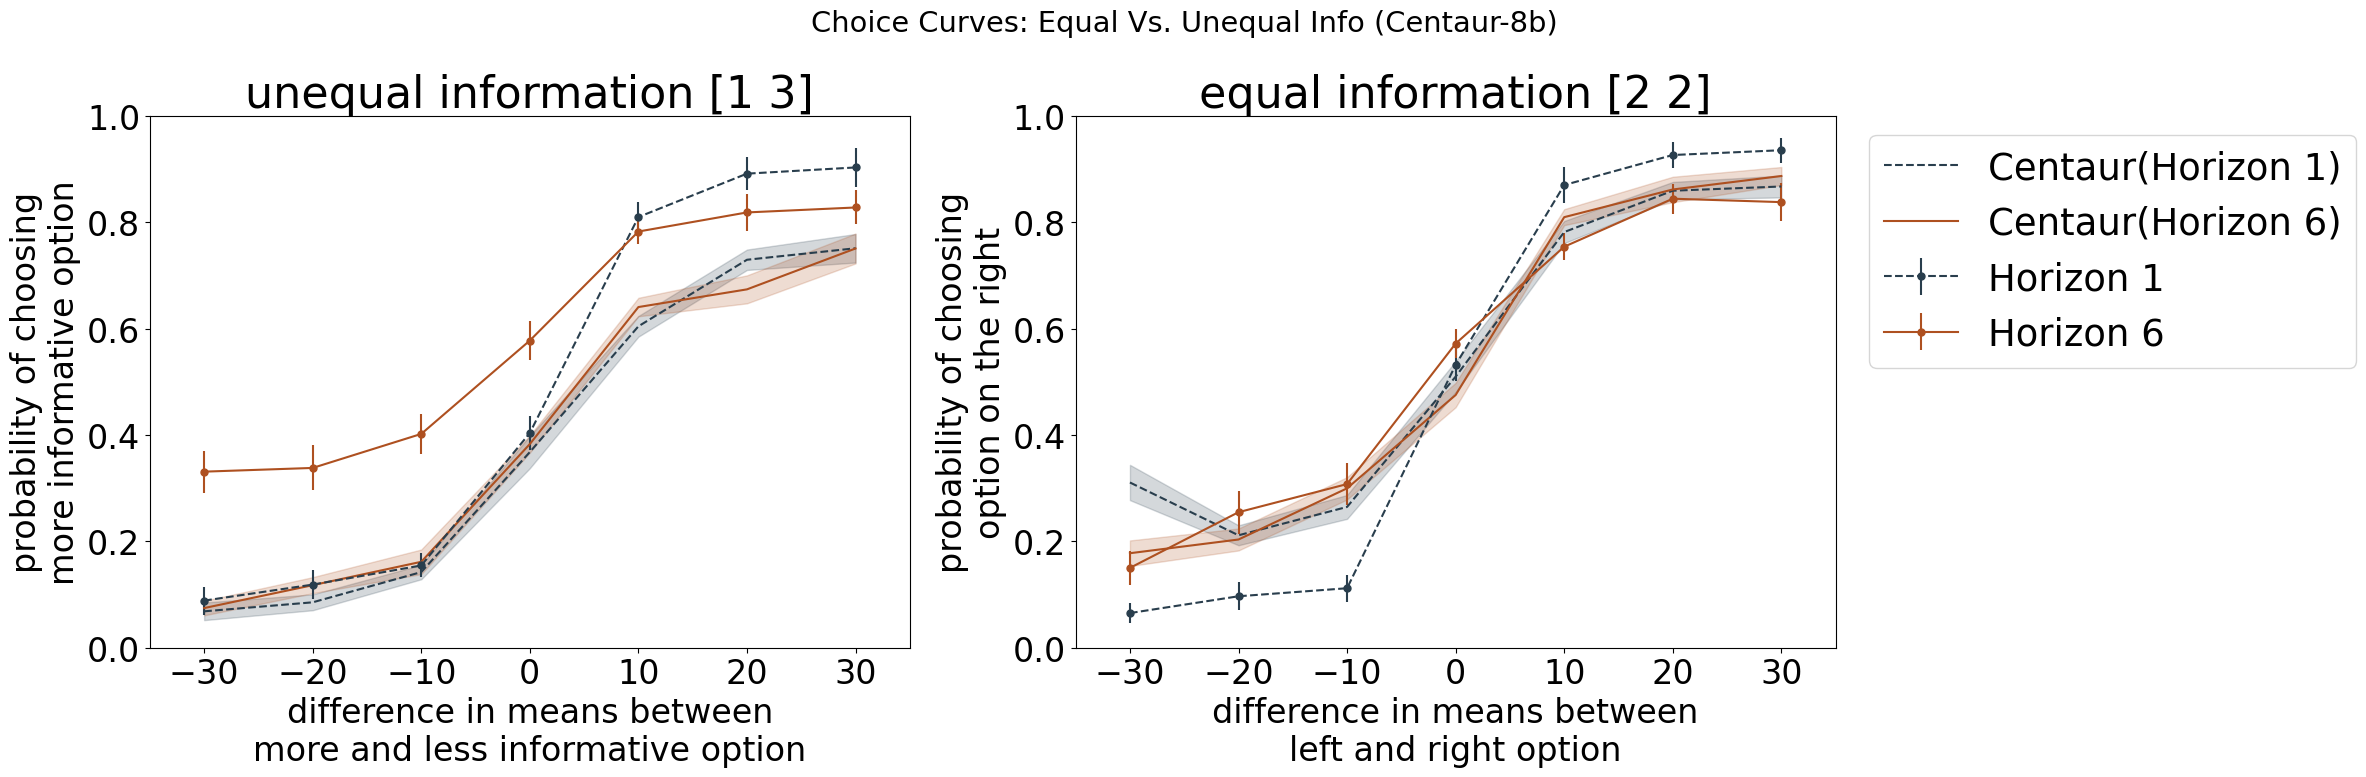

In [129]:
bin_edges=[-25,-15,-5,5,15,25]
RTmin=0.1
RTmax=3
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_new[0],AZred=colors_new[1])
plot_model_lines(ax, subjects_centaur, bin_edges,AZblue=colors_new[0],AZred=colors_new[1],label='Centaur')
#plot_model_lines(ax, subjects_rw, bin_edges,AZblue=colors_new[2],AZred=colors_new[3],label='Rescorla Wagner')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info (Centaur-8b)')
plt.tight_layout()
plt.show()

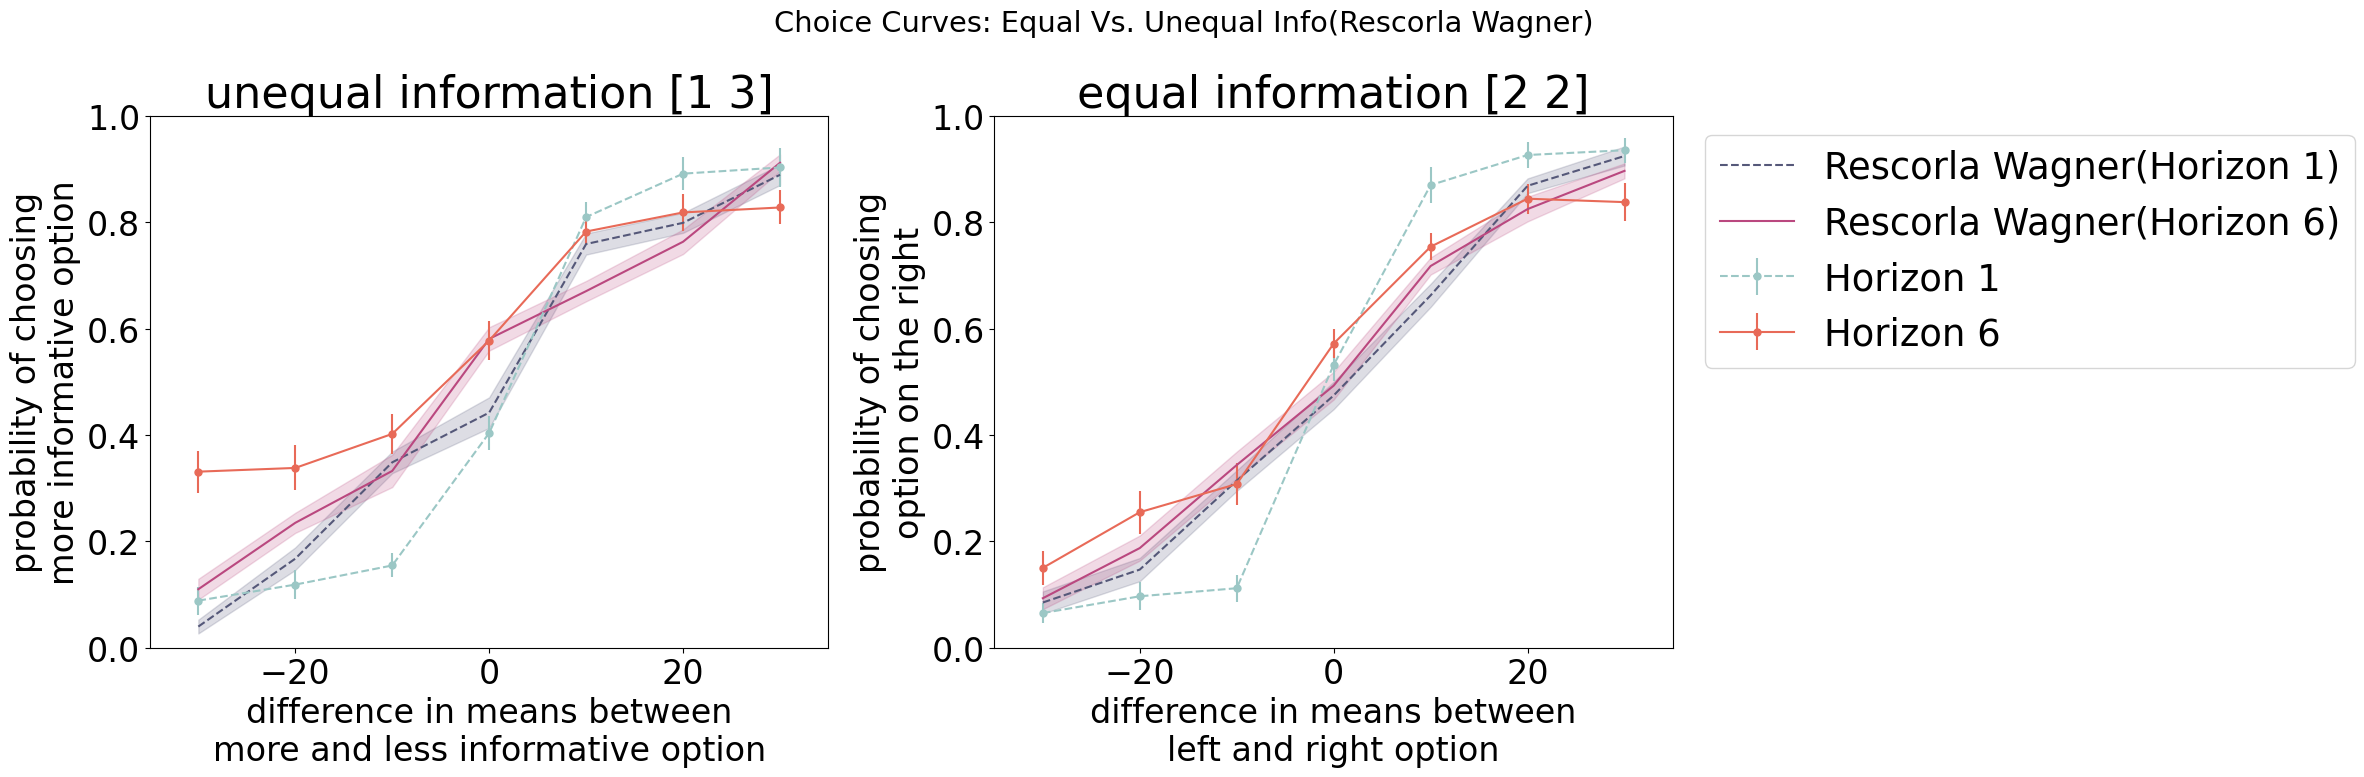

In [130]:
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_new[2],AZred=colors_new[3])
plot_model_lines(ax, subjects_rw, bin_edges,AZblue='#555879',AZred='#BA487F',label='Rescorla Wagner')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info(Rescorla Wagner)')
plt.tight_layout()
plt.show()

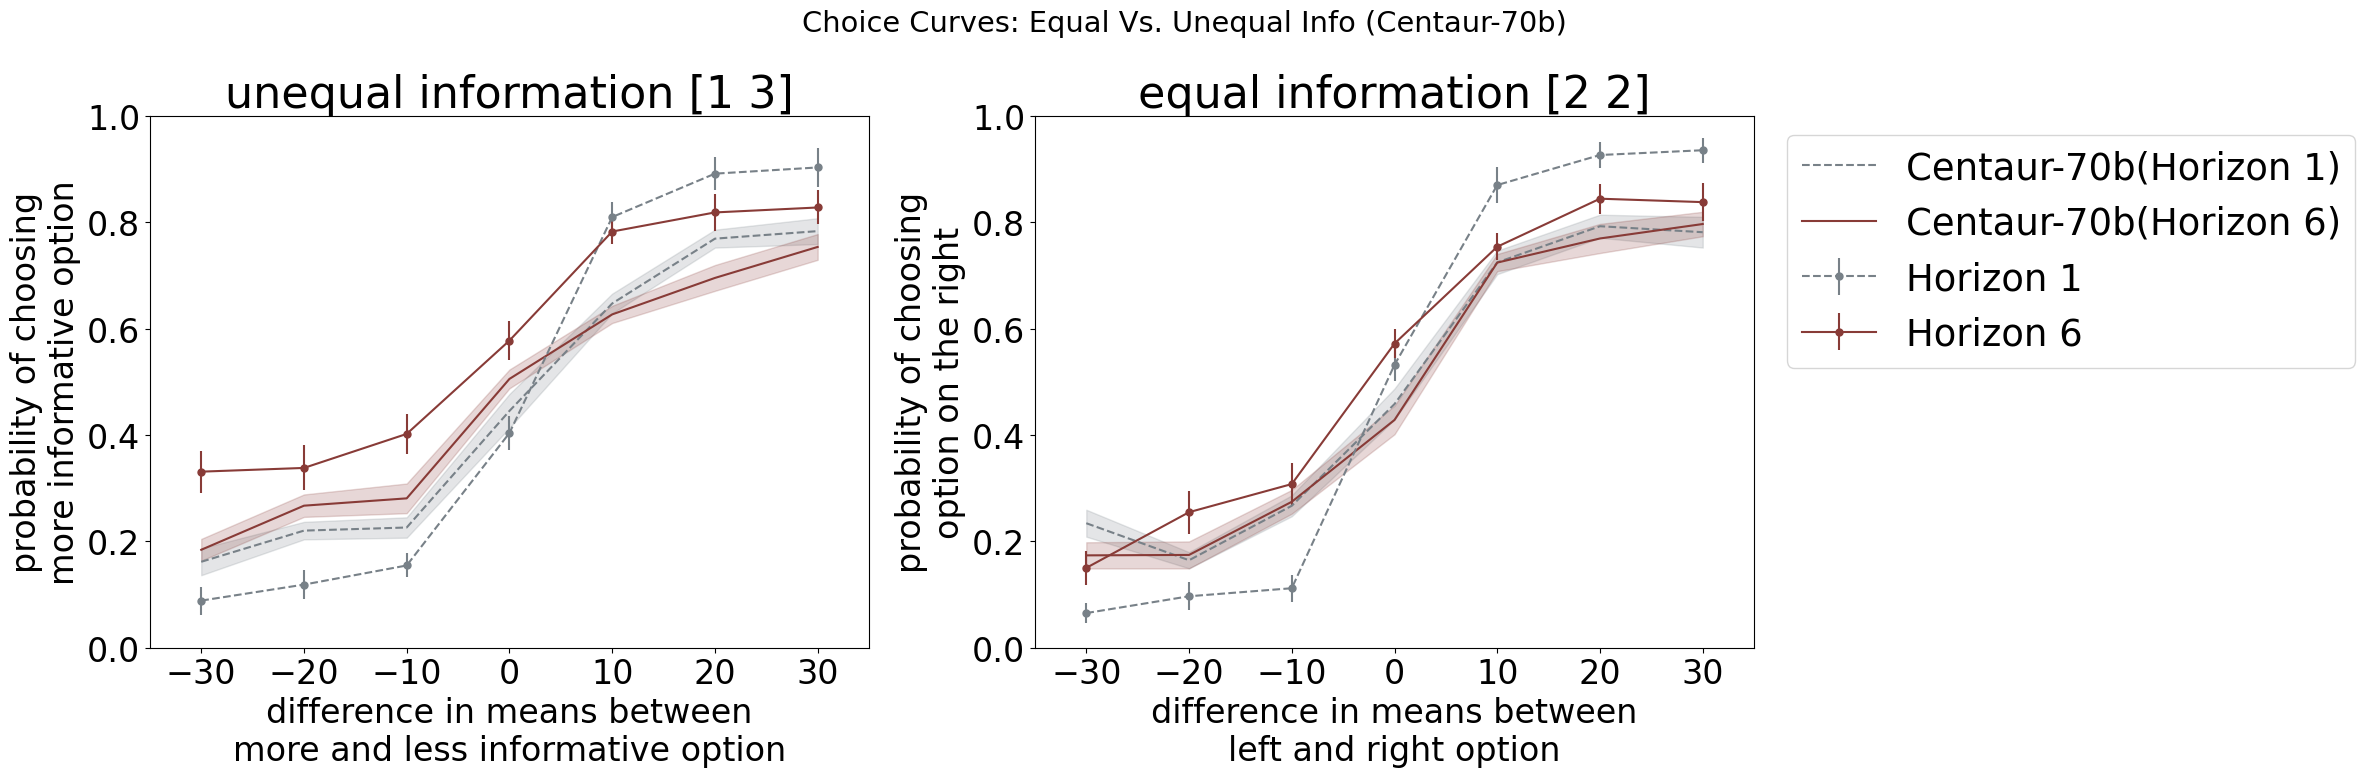

In [131]:
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_new[4],AZred=colors_new[5])
plot_model_lines(ax, subjects_centaur_70b, bin_edges,AZblue=colors_new[4],AZred=colors_new[5],label='Centaur-70b')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info (Centaur-70b)')
plt.tight_layout()
plt.show()

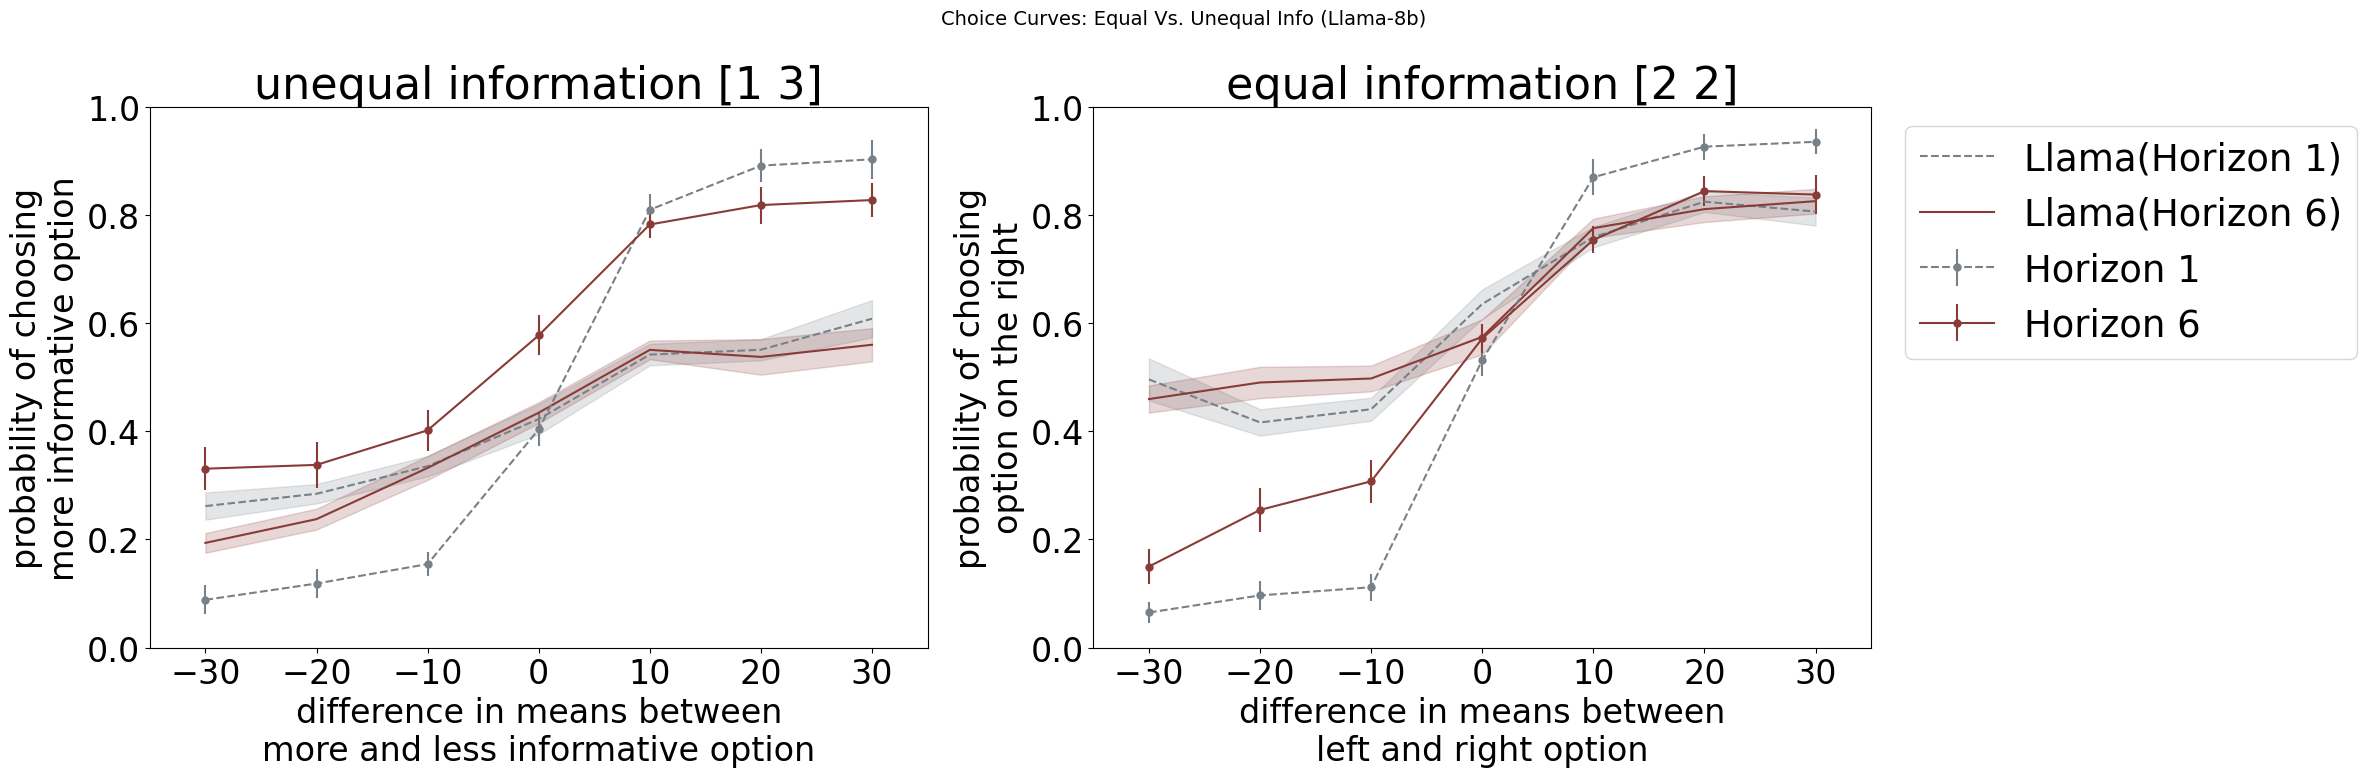

In [132]:
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_new[4],AZred=colors_new[5])
plot_model_lines(ax, subjects_llama, bin_edges,AZblue=colors_new[4],AZred=colors_new[5],label='Llama')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info (Llama-8b)', fontsize=14)
plt.tight_layout()
plt.show()

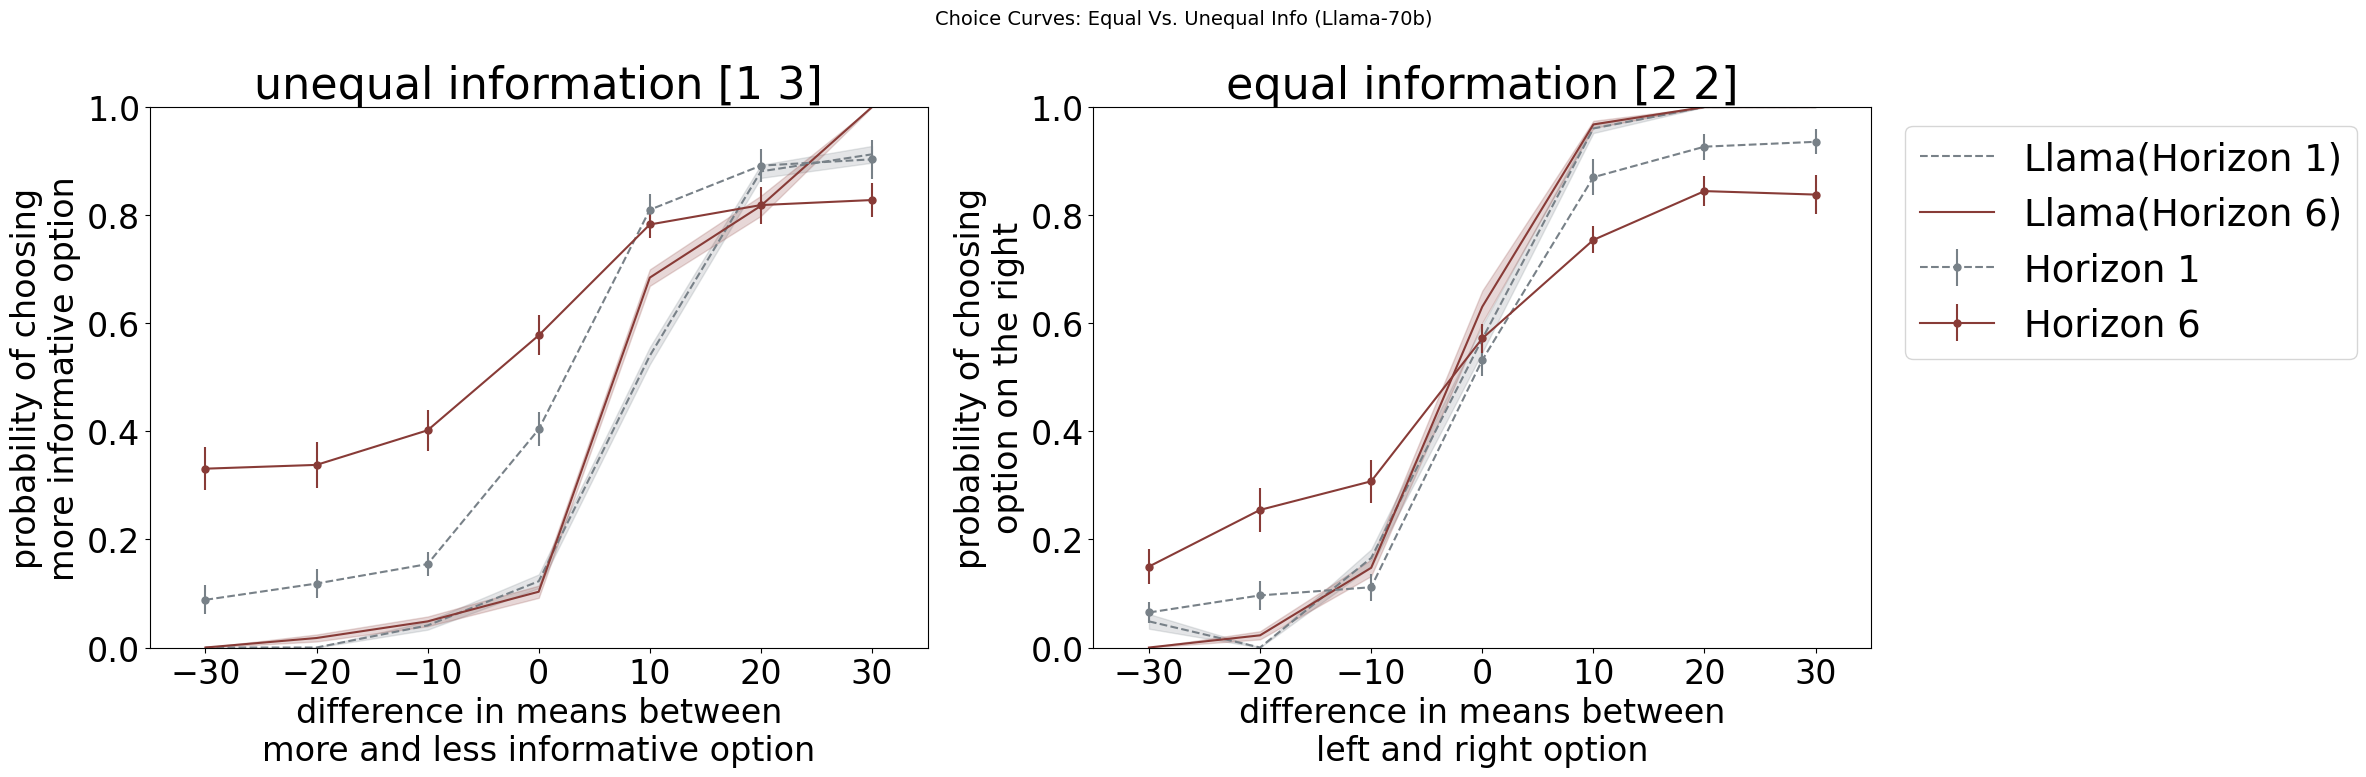

In [133]:
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_new[4],AZred=colors_new[5])
plot_model_lines(ax, subjects_llama_70b, bin_edges,AZblue=colors_new[4],AZred=colors_new[5],label='Llama')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info (Llama-70b)', fontsize=14)
plt.tight_layout()
plt.show()

### main fig 2c plot

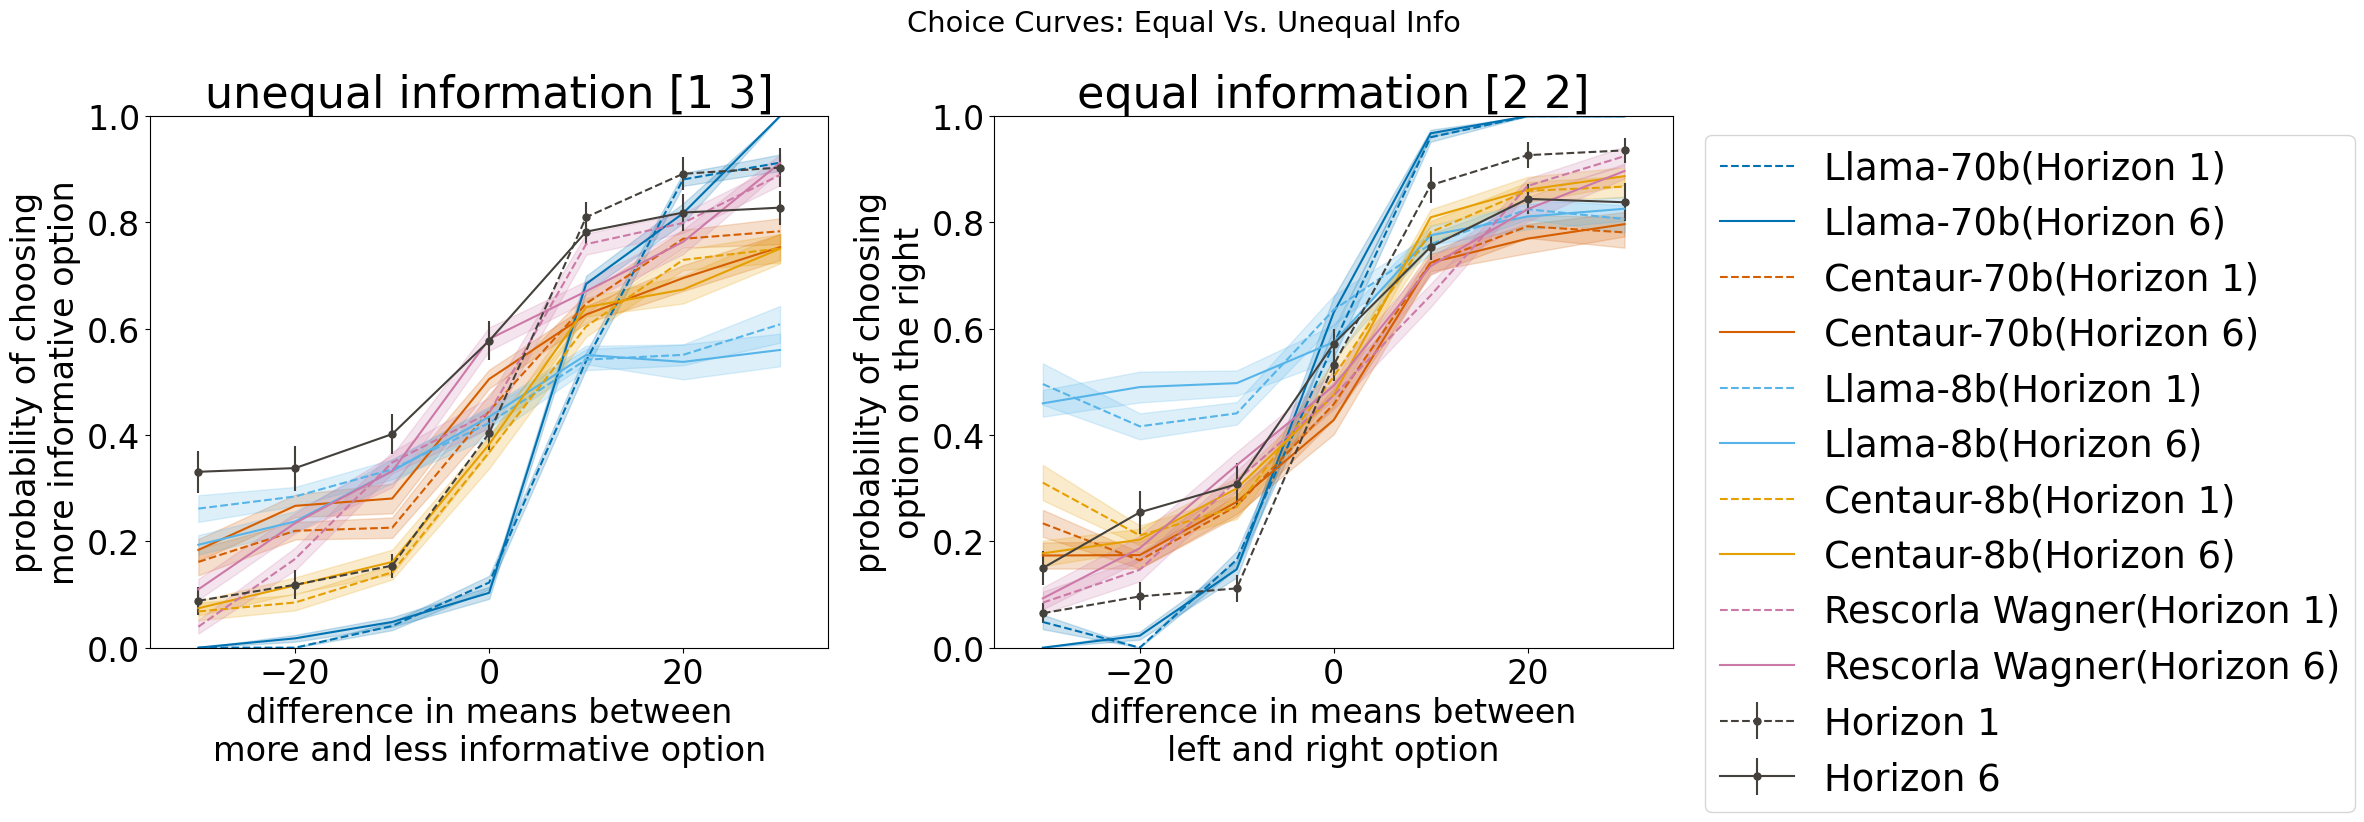

In [134]:
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_centaur_new[0],AZred=colors_centaur_new[0])
#plot_model_lines(ax, subjects_centaur, bin_edges,AZblue=colors_centaur_new[0],AZred=colors_centaur_new[1],label='Centaur')
plot_model_lines(ax, subjects_llama_70b, bin_edges,AZblue=colors_centaur_new[4],AZred=colors_centaur_new[4],label='Llama-70b')
plot_model_lines(ax, subjects_centaur_70b, bin_edges,AZblue=colors_centaur_new[2],AZred=colors_centaur_new[2],label='Centaur-70b')
plot_model_lines(ax, subjects_llama, bin_edges,AZblue=colors_centaur_new[3],AZred=colors_centaur_new[3],label='Llama-8b')
plot_model_lines(ax, subjects_centaur, bin_edges,AZblue=colors_centaur_new[1],AZred=colors_centaur_new[1],label='Centaur-8b')
plot_model_lines(ax, subjects_rw, bin_edges,AZblue=colors_centaur_new[5],AZred=colors_centaur_new[5],label='Rescorla Wagner')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info')
plt.tight_layout()
plt.show()

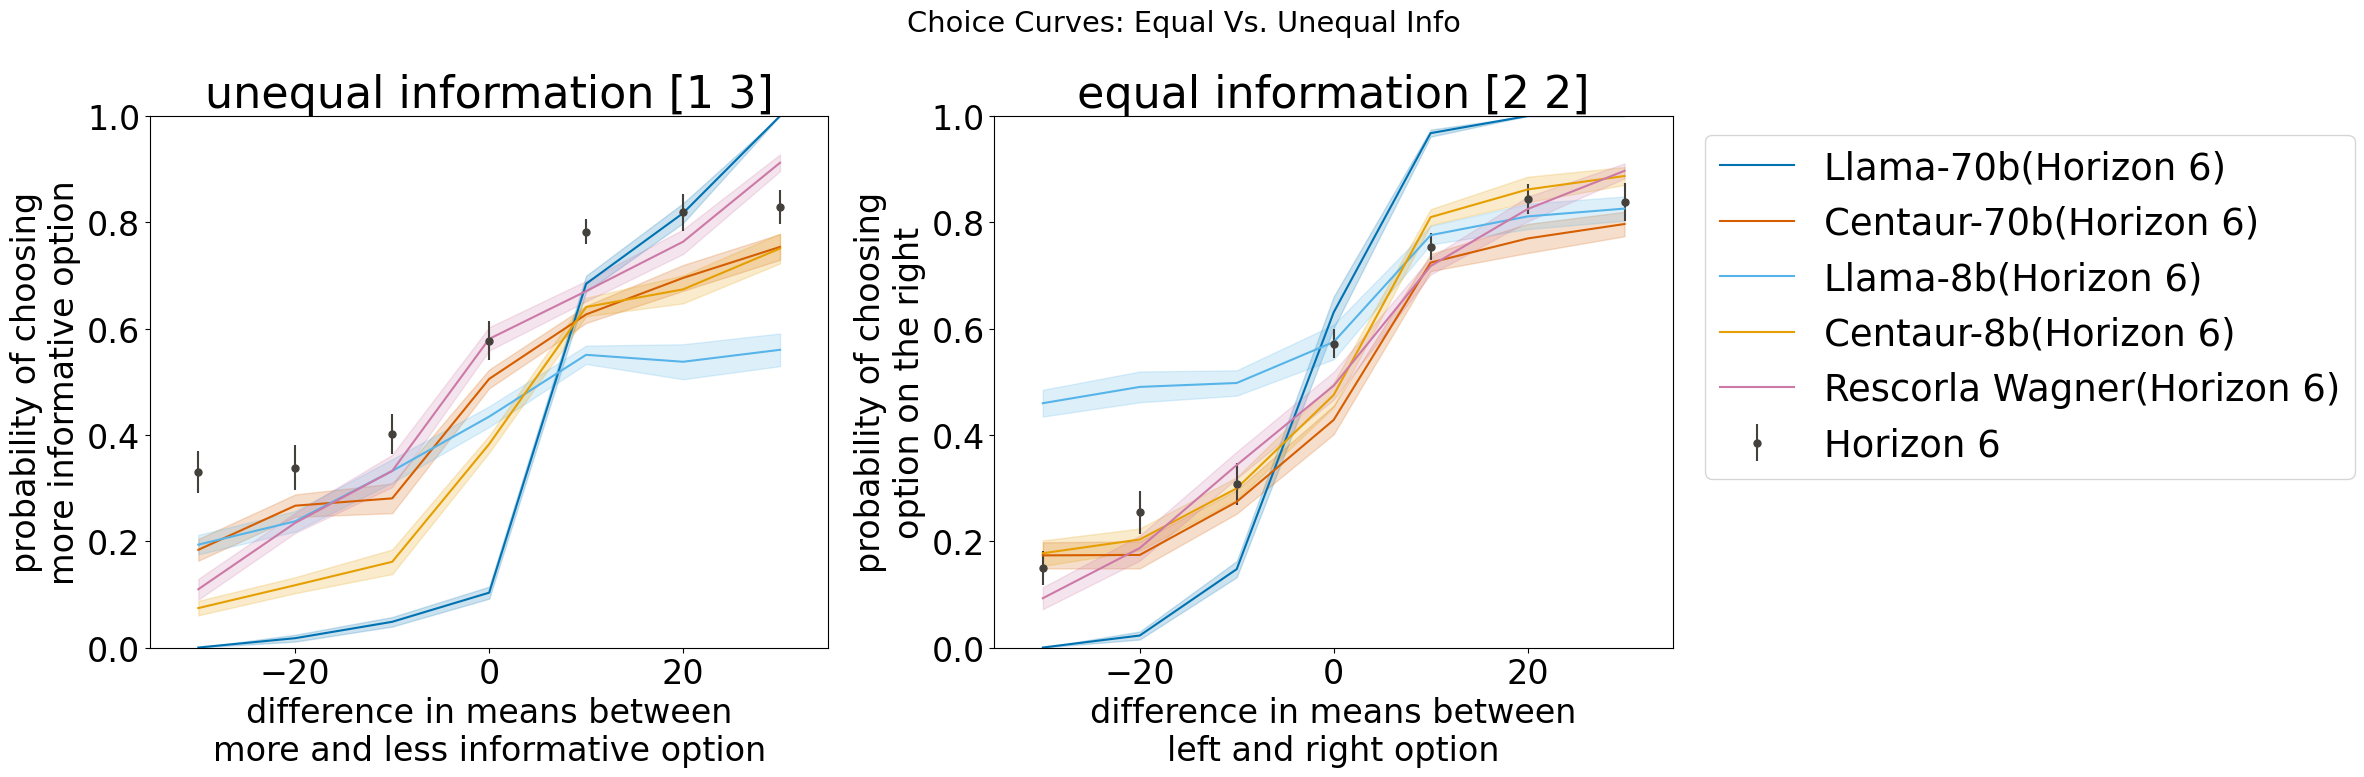

In [135]:
fig, ax = plt.subplots(1,2,figsize=(24,8))
plot_choice_curves_v2_h6(ax, subjects_pilot, bin_edges, RTmin, RTmax,AZblue=colors_centaur_new[0],AZred=colors_centaur_new[0])
#plot_model_lines(ax, subjects_centaur, bin_edges,AZblue=colors_centaur_new[0],AZred=colors_centaur_new[1],label='Centaur')
plot_model_lines_h6(ax, subjects_llama_70b, bin_edges,AZblue=colors_centaur_new[4],AZred=colors_centaur_new[4],label='Llama-70b')
plot_model_lines_h6(ax, subjects_centaur_70b, bin_edges,AZblue=colors_centaur_new[2],AZred=colors_centaur_new[2],label='Centaur-70b')
plot_model_lines_h6(ax, subjects_llama, bin_edges,AZblue=colors_centaur_new[3],AZred=colors_centaur_new[3],label='Llama-8b')
plot_model_lines_h6(ax, subjects_centaur, bin_edges,AZblue=colors_centaur_new[1],AZred=colors_centaur_new[1],label='Centaur-8b')
plot_model_lines_h6(ax, subjects_rw, bin_edges,AZblue=colors_centaur_new[5],AZred=colors_centaur_new[5],label='Rescorla Wagner')
fig.suptitle('Choice Curves: Equal Vs. Unequal Info')
plt.tight_layout()
plt.show()